# Enron Fruad 项目概述
### 在此项目中，你将扮演侦探，运用你的机器学习技能构建一个算法，通过公开的安然财务和邮件数据集，找出有欺诈嫌疑的安然雇员。

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook
from scipy.stats import trim_mean
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import pickle

from __future__ import division
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import classification_report, mean_absolute_error, r2_score, mean_squared_error
from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from feature_format import featureFormat
from feature_format import targetFeatureSplit

data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

/Users/Joel/anaconda/envs/py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## 数据探索
- 数据点总数
- 类之间的分配（POI/非 POI）
- 使用的特征数量
- 是否有哪些特征有很多缺失值？等。

In [3]:
df = pd.DataFrame(data_dict).T
df.head()

bonus deferral_payments deferred_income director_fees  \
ALLEN PHILLIP K     4175000           2869717        -3081055           NaN   
BADUM JAMES P           NaN            178980             NaN           NaN   
BANNANTINE JAMES M      NaN               NaN           -5104           NaN   
BAXTER JOHN C       1200000           1295738        -1386055           NaN   
BAY FRANKLIN R       400000            260455         -201641           NaN   

                                 email_address exercised_stock_options  \
ALLEN PHILLIP K        phillip.allen@enron.com                 1729541   
BADUM JAMES P                              NaN                  257817   
BANNANTINE JAMES M  james.bannantine@enron.com                 4046157   
BAXTER JOHN C                              NaN                 6680544   
BAY FRANKLIN R             frank.bay@enron.com                     NaN   

                   expenses from_messages from_poi_to_this_person  \
ALLEN PHILLIP K       13868          2195                      47   
BADUM JAMES P          3486           NaN                     NaN   
BANNANTINE JAMES M    56301            29                      39   
BAXTER JOHN C         11200           NaN                     NaN   
BAY FRANKLIN R       129142           NaN                     NaN   

                   from_this_person_to_poi        ...         \
ALLEN PHILLIP K                         65        ...          
BADUM JAMES P                          NaN        ...          
BANNANTINE JAMES M                       0        ...          
BAXTER JOHN C                          NaN        ...          
BAY FRANKLIN R                         NaN        ...          

                   long_term_incentive    other    poi restricted_stock  \
ALLEN PHILLIP K                 304805      152  False           126027   
BADUM JAMES P                      NaN      NaN  False              NaN   
BANNANTINE JAMES M                 NaN   864523  False          1757552   
BAXTER JOHN C                  1586055  2660303  False          3942714   
BAY FRANKLIN R                     NaN       69  False           145796   

                   restricted_stock_deferred  salary shared_receipt_with_poi  \
ALLEN PHILLIP K                      -126027  201955                    1407   
BADUM JAMES P                            NaN     NaN                     NaN   
BANNANTINE JAMES M                   -560222     477                     465   
BAXTER JOHN C                            NaN  267102                     NaN   
BAY FRANKLIN R                        -82782  239671                     NaN   

                   to_messages total_payments total_stock_value  
ALLEN PHILLIP K           2902        4484442           1729541  
BADUM JAMES P              NaN         182466            257817  
BANNANTINE JAMES M         566         916197           5243487  
BAXTER JOHN C              NaN        5634343          10623258  
BAY FRANKLIN R             NaN         827696             63014  

[5 rows x 21 columns]

### 数据点总数
- 146嫌疑犯，21個特征，包含「财务特征」，「邮件特征」，「POI 标签」

In [4]:
df.shape

(146, 21)

### 类之间的分配

- 「财务特征」為 Numerical

- 「邮件特征」為 Numerical / Text

- 「POI标签」為 Categorical


In [37]:
df.dtypes

bonus                        object
deferral_payments            object
deferred_income              object
director_fees                object
email_address                object
exercised_stock_options      object
expenses                     object
from_messages                object
from_poi_to_this_person      object
from_this_person_to_poi      object
loan_advances                object
long_term_incentive          object
other                        object
poi                          object
restricted_stock             object
restricted_stock_deferred    object
salary                       object
shared_receipt_with_poi      object
to_messages                  object
total_payments               object
total_stock_value            object
dtype: object

In [4]:
df.columns.values
flt_col = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'loan_advances', 'long_term_incentive',
       'other', 'restricted_stock', 'restricted_stock_deferred',
       'salary', 'shared_receipt_with_poi', 'to_messages',
       'total_payments', 'total_stock_value']

### 把「email_address」，「poi」以外做轉換型態

In [5]:
df[flt_col] = df[flt_col].apply(pd.to_numeric, errors='coerce')
df.dtypes

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
email_address                 object
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                           object
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

### 使用的特征数量
### 是否有哪些特征有很多缺失值？等

In [6]:
df_miss = df.select_dtypes(include = ['float64', 'int64'])#.iloc[:, 1:]
total = df_miss.isnull().sum().sort_values(ascending=False)
pd.DataFrame(total, columns=['Missing Values'])

Missing Values
loan_advances                         142
director_fees                         129
restricted_stock_deferred             128
deferral_payments                     107
deferred_income                        97
long_term_incentive                    80
bonus                                  64
from_this_person_to_poi                60
from_poi_to_this_person                60
from_messages                          60
shared_receipt_with_poi                60
to_messages                            60
other                                  53
expenses                               51
salary                                 51
exercised_stock_options                44
restricted_stock                       36
total_payments                         21
total_stock_value                      20

### 遺失值過多的Feature，丟失過多數據，不適用填充值方式取代
- loan_advances	142
- director_fees	129
- restricted_stock_deferred	128
- deferral_payments	107
- deferred_income	97
- long_term_incentive	80

### 遺失值比較少的Feature
- exercised_stock_options	44
- restricted_stock	36
- total_payments	21
- total_stock_value	20


#### 針對遺失值較少的處理方式
- 透過相關性，檢查是跟否存在規律

<IPython.core.display.Javascript object>


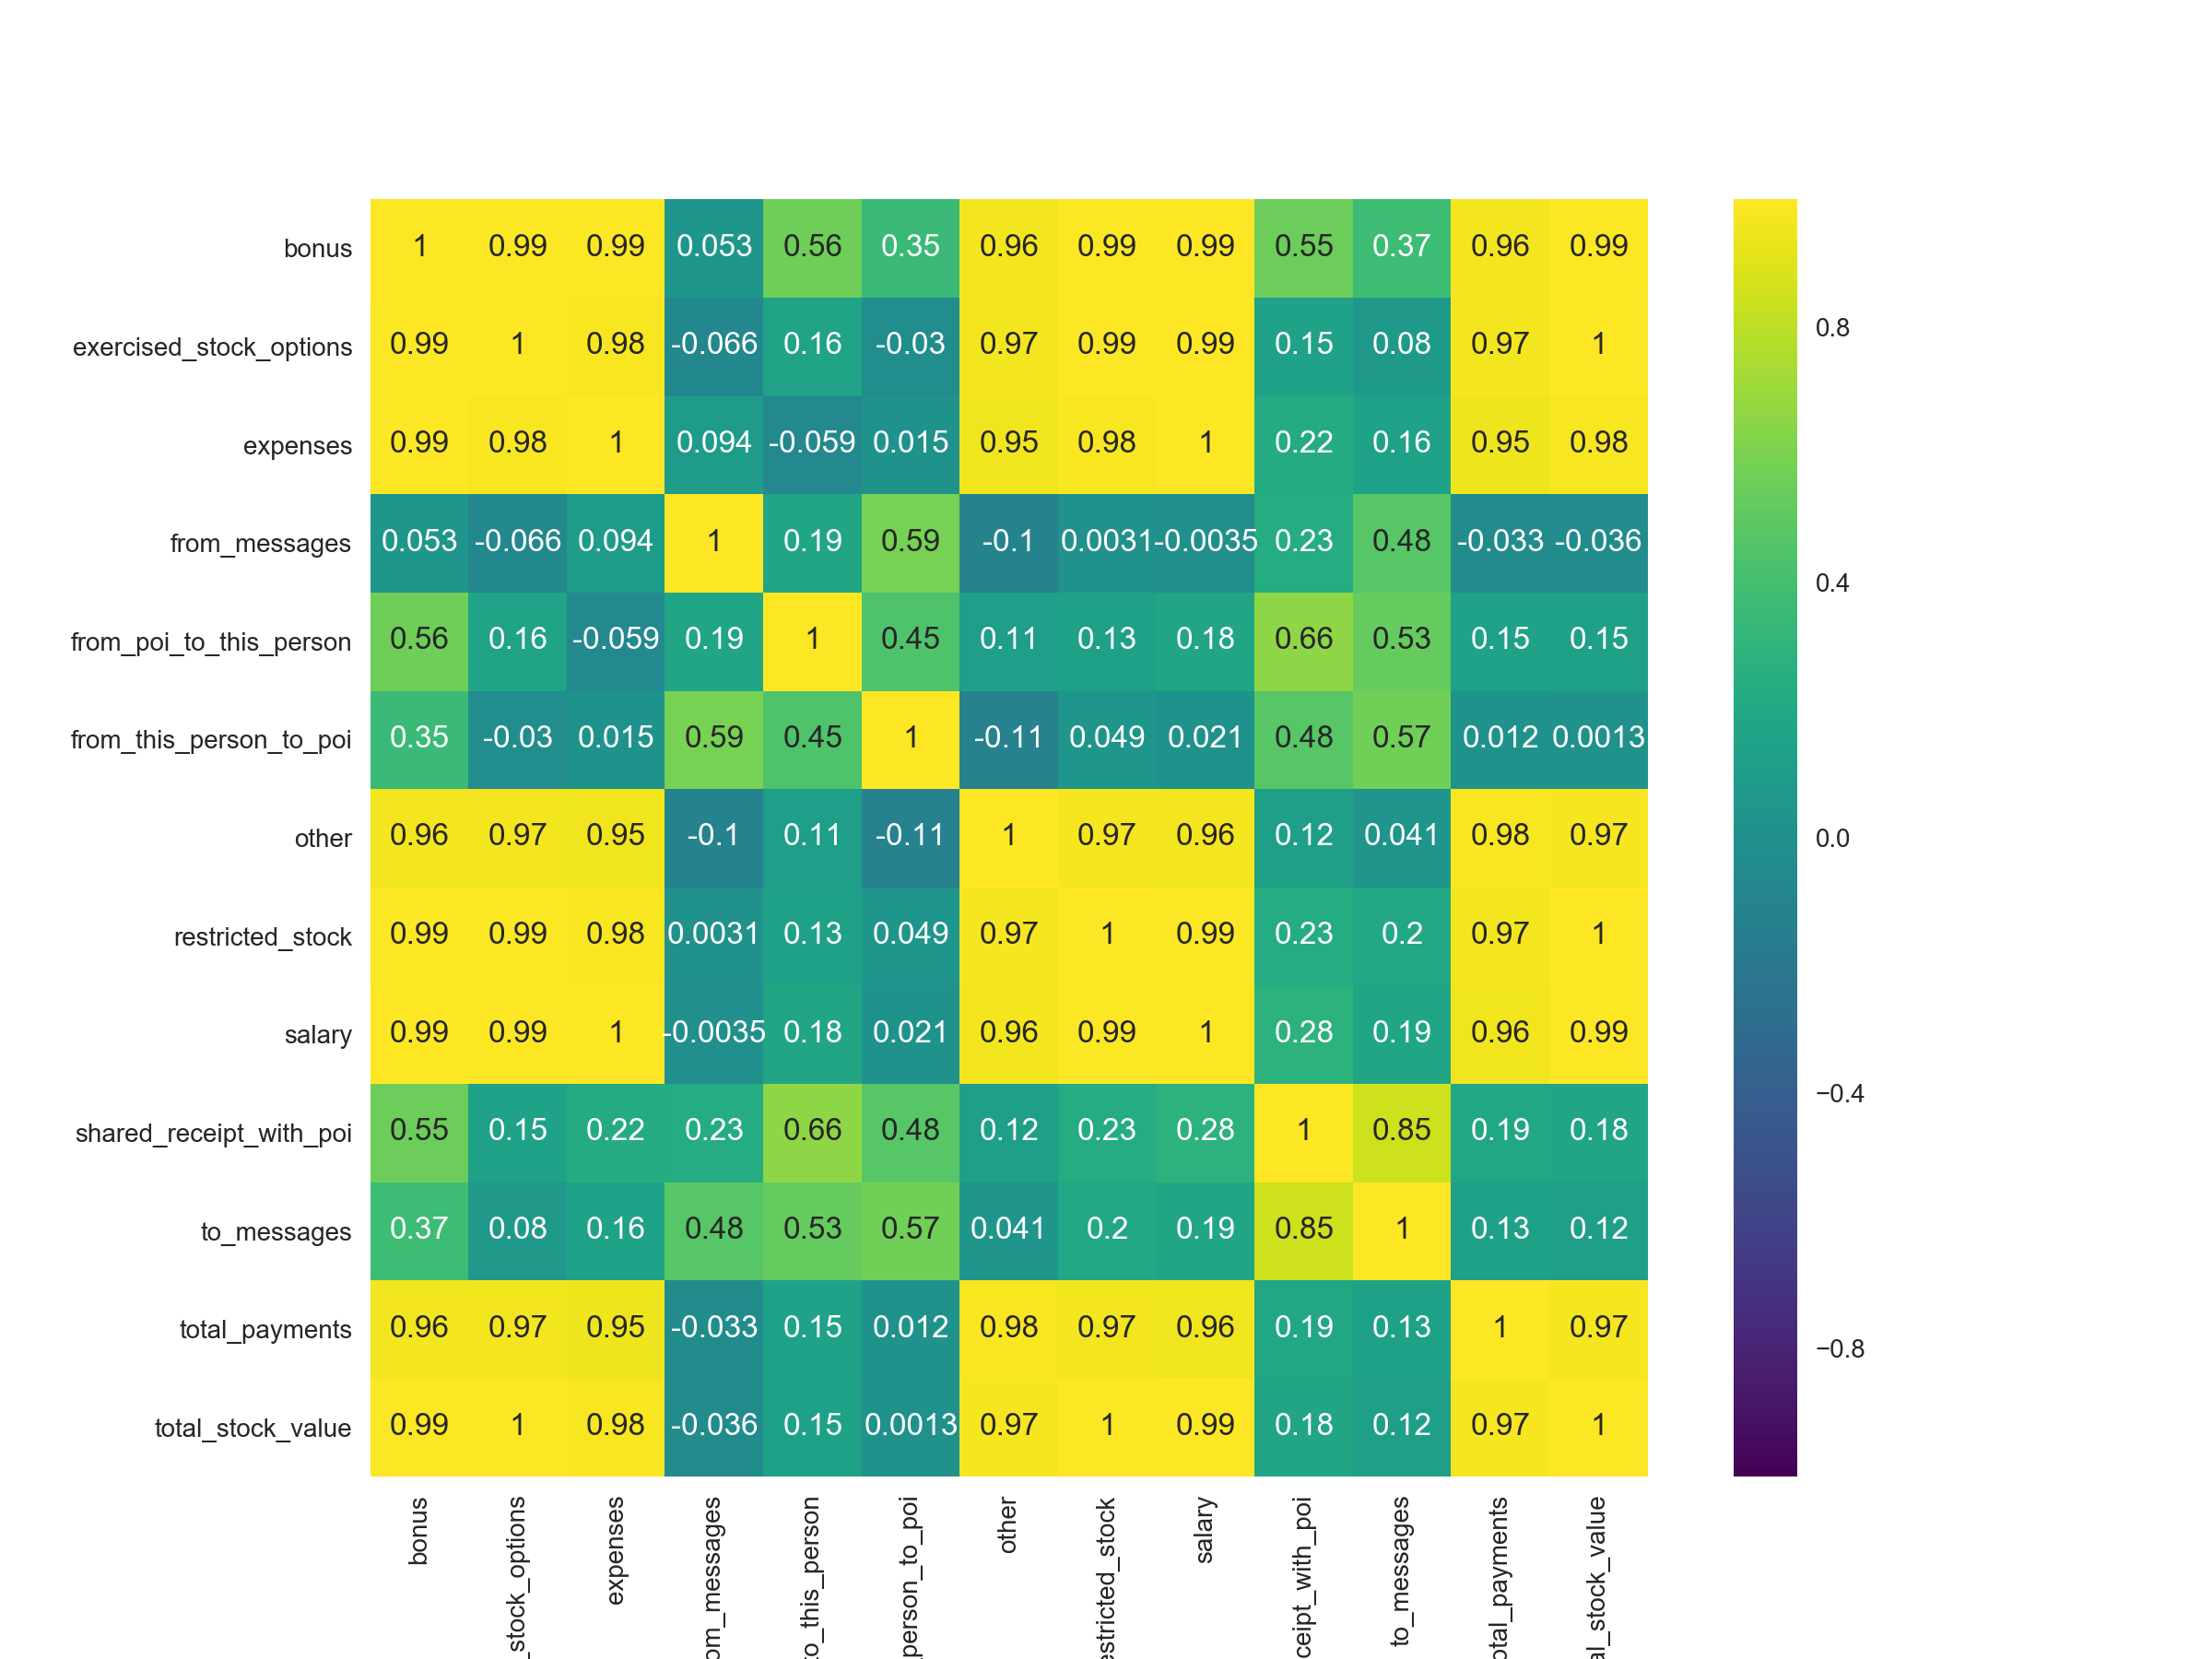

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5]), <a list of 13 Text yticklabel objects>)

In [6]:
dropf = ['loan_advances','director_fees','restricted_stock_deferred',
         'deferral_payments','deferred_income','long_term_incentive']

# 移除遺失過多的feature
df_less = df.drop(dropf ,axis=1).copy()

corrmat = df_less.select_dtypes(include = ['float64', 'int64']).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True, cmap='viridis', square=True);
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 

高度相關性的特徵值
**bonus, exercised_stock_options, expense, other, restricted_stock, salary, total_payments, total_stock_value**

### 處理遺失值
 - 嘗試用**Regression**方式，能否預測出遺失值少的 **total_stock_value，total_payments**
     1. 先把以上Features，移除NaN，看剩下多少樣本數
     2. 如果數量夠，就採用Train/test split，去做訓練，驗證評估：R Square數值。


In [7]:
candidate = [ 'bonus', 'exercised_stock_options', 'expenses', 'other', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value']
df_less = df_less[candidate].fillna(0)

In [8]:
df_less = df_less[df_less['bonus']>0]
df_less = df_less[df_less['salary']>0]
df_less = df_less[df_less['total_stock_value']>0]
df_less = df_less[df_less['total_payments']>0]
df_less.shape

(79, 8)

- 樣本數只有79個，先做數據處理

In [130]:
train = df_less[['bonus','salary','total_stock_value']]
y_train = df_less.total_payments
Xtrain, Xtest, ytrain, ytest = train_test_split(train, y_train, test_size = 0.2, random_state = None)

In [131]:

Stand = StandardScaler()
Xtrain = Stand.fit_transform(Xtrain)
Xtest = Stand.fit_transform(Xtest)

### Regressor 回歸模型
1. GradientBoostingRegressor
2. RandomForestRegressor

In [132]:
gb_reg = GradientBoostingRegressor()
rf_reg = RandomForestRegressor()

gb_reg.fit(Xtrain, ytrain)
rf_reg.fit(Xtrain, ytrain)

ygb_pred = gb_reg.predict(Xtest)
yrf_pred = rf_reg.predict(Xtest)
print('GBR R Square: %d'%(r2_score(ytest, ygb_pred)))
print('RF R Square: %d'%(r2_score(ytest, yrf_pred)))
print('GBR MAE: %d'%(mean_squared_error(ytest, ygb_pred)))
print('RF MAE: %d'%(mean_squared_error(ytest, yrf_pred)))

GBR R Square: -1
RF R Square: 0
GBR MAE: 693093869392141
RF MAE: 444794522542109


### 結論：Regression 插值，全部不可行，Std 過大

In [144]:
df.describe()

bonus  deferral_payments  deferred_income  director_fees  \
count  1.460000e+02       1.460000e+02     1.460000e+02   1.460000e+02   
mean   1.333474e+06       4.387965e+05    -3.827622e+05   1.942249e+04   
std    8.094029e+06       2.741325e+06     2.378250e+06   1.190543e+05   
min    0.000000e+00      -1.025000e+05    -2.799289e+07   0.000000e+00   
25%    0.000000e+00       0.000000e+00    -3.792600e+04   0.000000e+00   
50%    3.000000e+05       0.000000e+00     0.000000e+00   0.000000e+00   
75%    8.000000e+05       9.684500e+03     0.000000e+00   0.000000e+00   
max    9.734362e+07       3.208340e+07     0.000000e+00   1.398517e+06   

       exercised_stock_options      expenses  from_messages  \
count             1.460000e+02  1.460000e+02     146.000000   
mean              4.182736e+06  7.074827e+04     358.602740   
std               2.607040e+07  4.327163e+05    1441.259868   
min               0.000000e+00  0.000000e+00       0.000000   
25%               0.000000e+00  0.000000e+00       0.000000   
50%               6.082935e+05  2.018200e+04      16.500000   
75%               1.714221e+06  5.374075e+04      51.250000   
max               3.117640e+08  5.235198e+06   14368.000000   

       from_poi_to_this_person  from_this_person_to_poi  loan_advances  \
count               146.000000               146.000000   1.460000e+02   
mean                 38.226027                24.287671   1.149658e+06   
std                  73.901124                79.278206   9.649342e+06   
min                   0.000000                 0.000000   0.000000e+00   
25%                   0.000000                 0.000000   0.000000e+00   
50%                   2.500000                 0.000000   0.000000e+00   
75%                  40.750000                13.750000   0.000000e+00   
max                 528.000000               609.000000   8.392500e+07   

       long_term_incentive         other         poi  restricted_stock  \
count         1.460000e+02  1.460000e+02  146.000000      1.460000e+02   
mean          6.646839e+05  5.854318e+05    0.123288      1.749257e+06   
std           4.046072e+06  3.682345e+06    0.329899      1.089995e+07   
min           0.000000e+00  0.000000e+00    0.000000     -2.604490e+06   
25%           0.000000e+00  0.000000e+00    0.000000      8.115000e+03   
50%           0.000000e+00  9.595000e+02    0.000000      3.605280e+05   
75%           3.750648e+05  1.506065e+05    0.000000      8.145280e+05   
max           4.852193e+07  4.266759e+07    1.000000      1.303223e+08   

       restricted_stock_deferred        salary  shared_receipt_with_poi  \
count               1.460000e+02  1.460000e+02               146.000000   
mean                2.051637e+04  3.658114e+05               692.986301   
std                 1.439661e+06  2.203575e+06              1072.969492   
min                -7.576788e+06  0.000000e+00                 0.000000   
25%                 0.000000e+00  0.000000e+00                 0.000000   
50%                 0.000000e+00  2.105960e+05               102.500000   
75%                 0.000000e+00  2.708505e+05               893.500000   
max                 1.545629e+07  2.670423e+07              5521.000000   

        to_messages  total_payments  total_stock_value  
count    146.000000    1.460000e+02       1.460000e+02  
mean    1221.589041    4.350622e+06       5.846018e+06  
std     2226.770637    2.693448e+07       3.624681e+07  
min        0.000000    0.000000e+00      -4.409300e+04  
25%        0.000000    9.394475e+04       2.288695e+05  
50%      289.000000    9.413595e+05       9.659550e+05  
75%     1585.750000    1.968287e+06       2.319991e+06  
max    15149.000000    3.098866e+08       4.345095e+08

### 處理遺失值，把NaN全部改成0
- Std過大，不適合用interpolate內插法
- 樣本過少，不適合插入中位數，或是平均值

In [7]:
df = df.fillna(0)
df.head()

bonus  deferral_payments  deferred_income  \
ALLEN PHILLIP K     4175000.0          2869717.0       -3081055.0   
BADUM JAMES P             0.0           178980.0              0.0   
BANNANTINE JAMES M        0.0                0.0          -5104.0   
BAXTER JOHN C       1200000.0          1295738.0       -1386055.0   
BAY FRANKLIN R       400000.0           260455.0        -201641.0   

                    director_fees               email_address  \
ALLEN PHILLIP K               0.0     phillip.allen@enron.com   
BADUM JAMES P                 0.0                         NaN   
BANNANTINE JAMES M            0.0  james.bannantine@enron.com   
BAXTER JOHN C                 0.0                         NaN   
BAY FRANKLIN R                0.0         frank.bay@enron.com   

                    exercised_stock_options  expenses  from_messages  \
ALLEN PHILLIP K                   1729541.0   13868.0         2195.0   
BADUM JAMES P                      257817.0    3486.0            0.0   
BANNANTINE JAMES M                4046157.0   56301.0           29.0   
BAXTER JOHN C                     6680544.0   11200.0            0.0   
BAY FRANKLIN R                          0.0  129142.0            0.0   

                    from_poi_to_this_person  from_this_person_to_poi  \
ALLEN PHILLIP K                        47.0                     65.0   
BADUM JAMES P                           0.0                      0.0   
BANNANTINE JAMES M                     39.0                      0.0   
BAXTER JOHN C                           0.0                      0.0   
BAY FRANKLIN R                          0.0                      0.0   

                          ...          long_term_incentive      other    poi  \
ALLEN PHILLIP K           ...                     304805.0      152.0  False   
BADUM JAMES P             ...                          0.0        0.0  False   
BANNANTINE JAMES M        ...                          0.0   864523.0  False   
BAXTER JOHN C             ...                    1586055.0  2660303.0  False   
BAY FRANKLIN R            ...                          0.0       69.0  False   

                    restricted_stock  restricted_stock_deferred    salary  \
ALLEN PHILLIP K             126027.0                  -126027.0  201955.0   
BADUM JAMES P                    0.0                        0.0       0.0   
BANNANTINE JAMES M         1757552.0                  -560222.0     477.0   
BAXTER JOHN C              3942714.0                        0.0  267102.0   
BAY FRANKLIN R              145796.0                   -82782.0  239671.0   

                    shared_receipt_with_poi  to_messages  total_payments  \
ALLEN PHILLIP K                      1407.0       2902.0       4484442.0   
BADUM JAMES P                           0.0          0.0        182466.0   
BANNANTINE JAMES M                    465.0        566.0        916197.0   
BAXTER JOHN C                           0.0          0.0       5634343.0   
BAY FRANKLIN R                          0.0          0.0        827696.0   

                    total_stock_value  
ALLEN PHILLIP K             1729541.0  
BADUM JAMES P                257817.0  
BANNANTINE JAMES M          5243487.0  
BAXTER JOHN C              10623258.0  
BAY FRANKLIN R                63014.0  

[5 rows x 21 columns]

### Email Address 遺失值處理
- 邮件特征得知，最高訊息含量的，會跟poi有關，郵箱地址沒有什麼訊息含量

In [8]:
df = df.drop('email_address', axis = 1)

### 特征Poi處理
- 沒有存在遺失值
- 進行LabelEncoder編碼處理

In [29]:
df['poi'].unique()

array([0, 1])

In [9]:

label = LabelEncoder()
df['poi'] = label.fit_transform(df['poi'])
df['poi'].tail()

WINOKUR JR. HERBERT S    0
WODRASKA JOHN            0
WROBEL BRUCE             0
YEAGER F SCOTT           1
YEAP SOON                0
Name: poi, dtype: int64

## 异常值调查

### 找出 outlier
- 下圖得知，Salary超過2.5億，極端異常值

<IPython.core.display.Javascript object>


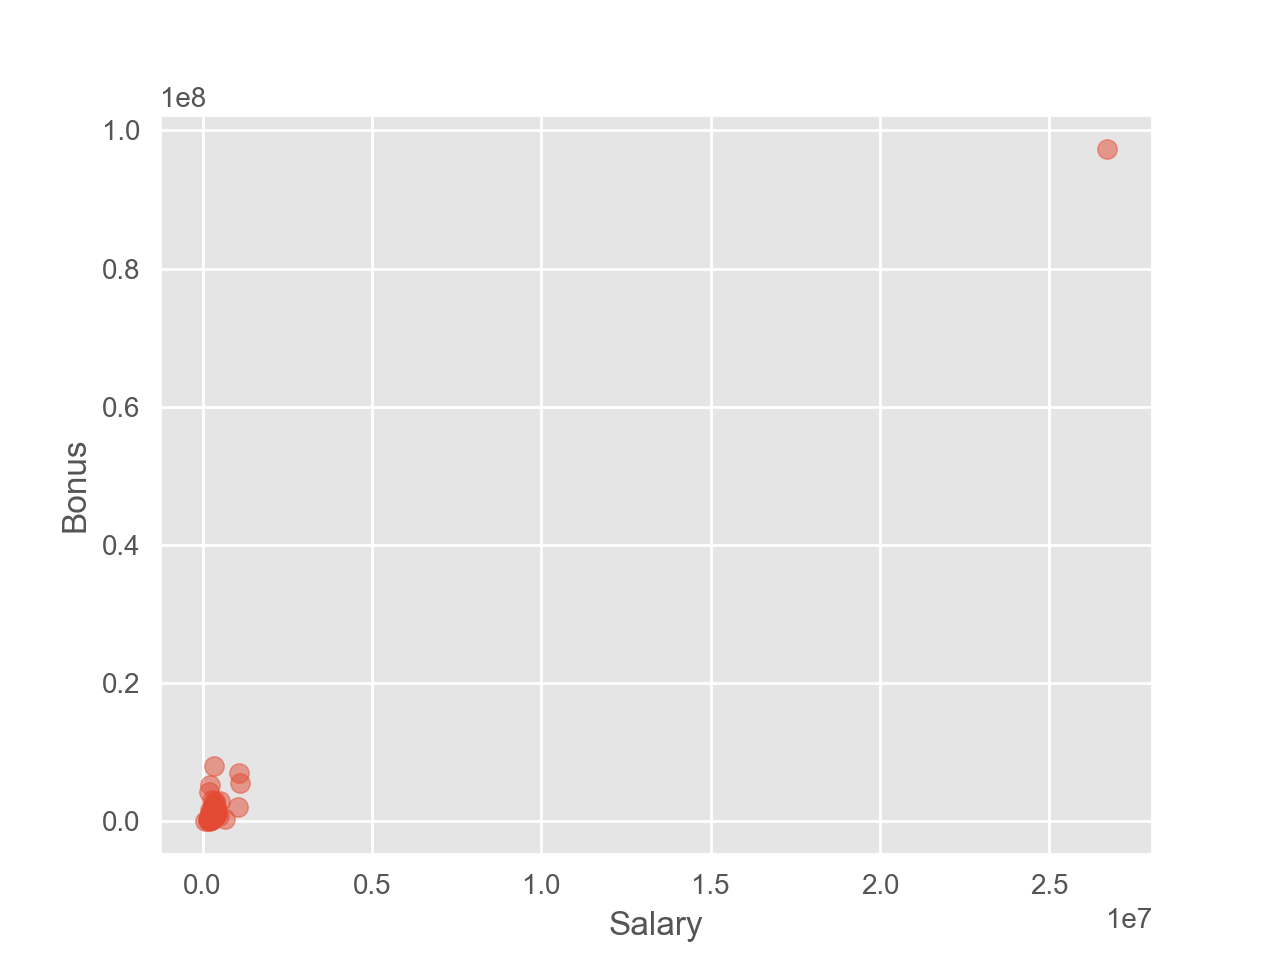

In [14]:
plt.scatter(df['salary'], df['bonus'], alpha=.5, edgecolors='face')
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

In [14]:
df[df['salary']>2.5e7]

bonus  deferral_payments  deferred_income  director_fees  \
TOTAL  97343619.0         32083396.0      -27992891.0      1398517.0   

      email_address  exercised_stock_options   expenses  from_messages  \
TOTAL           NaN              311764000.0  5235198.0            0.0   

       from_poi_to_this_person  from_this_person_to_poi        ...          \
TOTAL                      0.0                      0.0        ...           

       long_term_incentive       other  poi  restricted_stock  \
TOTAL           48521928.0  42667589.0    0       130322299.0   

       restricted_stock_deferred      salary  shared_receipt_with_poi  \
TOTAL                 -7576788.0  26704229.0                      0.0   

       to_messages  total_payments  total_stock_value  
TOTAL          0.0     309886585.0        434509511.0  

[1 rows x 21 columns]

### Total 不是個體單位，所以移除此欄位

In [10]:
df.drop('TOTAL', axis = 0, inplace = True)

### 從Scatter 查看分佈，依然有少數的異常

<IPython.core.display.Javascript object>


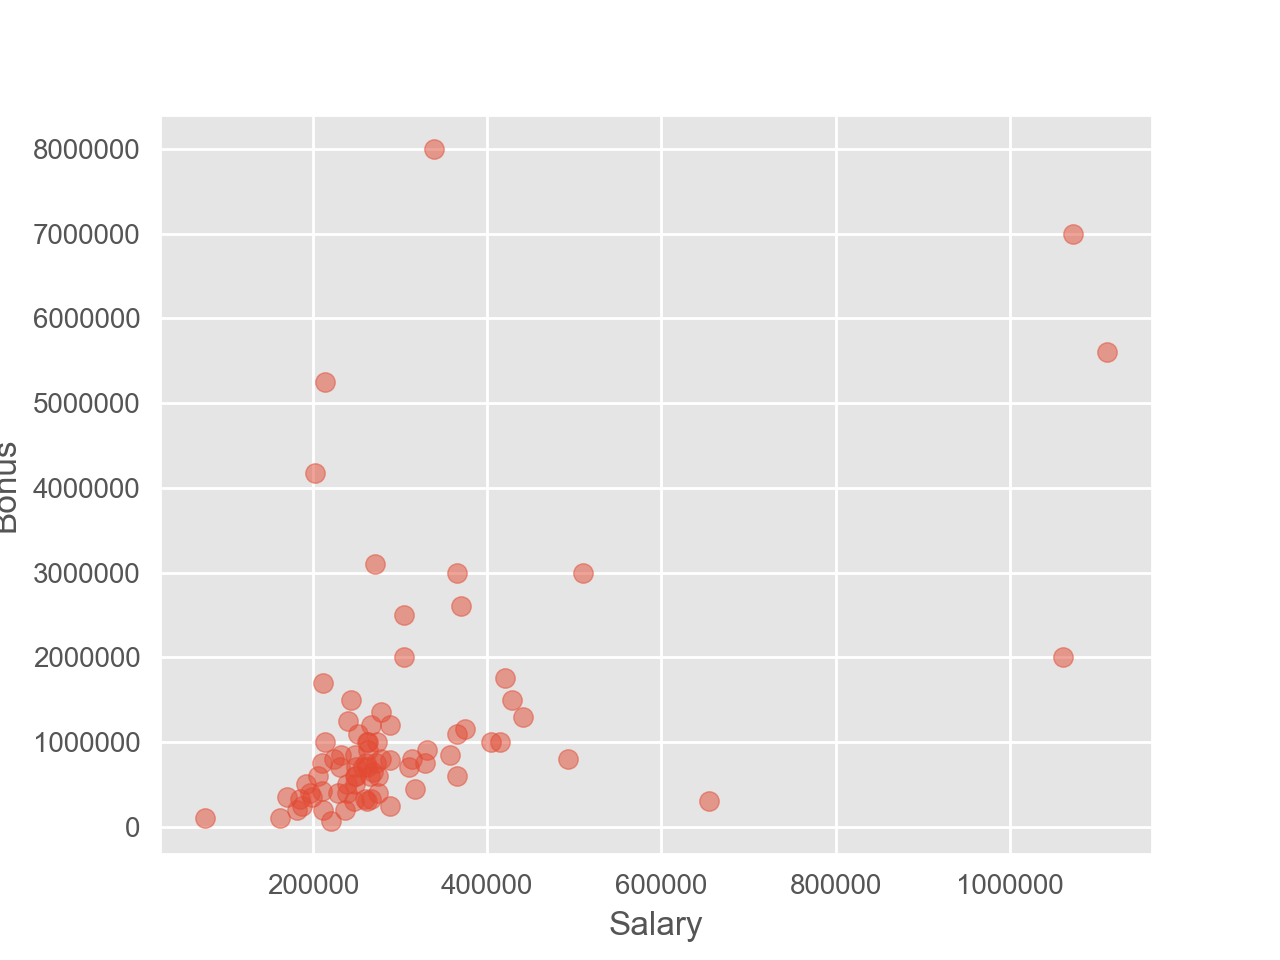

In [62]:
plt.scatter(df['salary'], df['bonus'], alpha=.5, edgecolors='face')
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

### 檢視 **薪資 / 獎金** 異常是哪些人

In [16]:
bonus_outliers = []
for k, v in zip(df.index, df['bonus']):
    bonus_outliers.append((k,v))
sorted(bonus_outliers,key=lambda x:x[1],reverse=True)[:6]

[('LAVORATO JOHN J', 8000000.0),
 ('LAY KENNETH L', 7000000.0),
 ('SKILLING JEFFREY K', 5600000.0),
 ('BELDEN TIMOTHY N', 5249999.0),
 ('ALLEN PHILLIP K', 4175000.0),
 ('KITCHEN LOUISE', 3100000.0)]

In [17]:
salary_outliers = []
for k , v in zip(df.index, df['salary']):
    salary_outliers.append((k,v))
sorted(salary_outliers,key=lambda x:x[1],reverse=True)[:6]

[('SKILLING JEFFREY K', 1111258.0),
 ('LAY KENNETH L', 1072321.0),
 ('FREVERT MARK A', 1060932.0),
 ('PICKERING MARK R', 655037.0),
 ('WHALLEY LAWRENCE G', 510364.0),
 ('DERRICK JR. JAMES V', 492375.0)]

- Poi 之間的信件往來

<IPython.core.display.Javascript object>


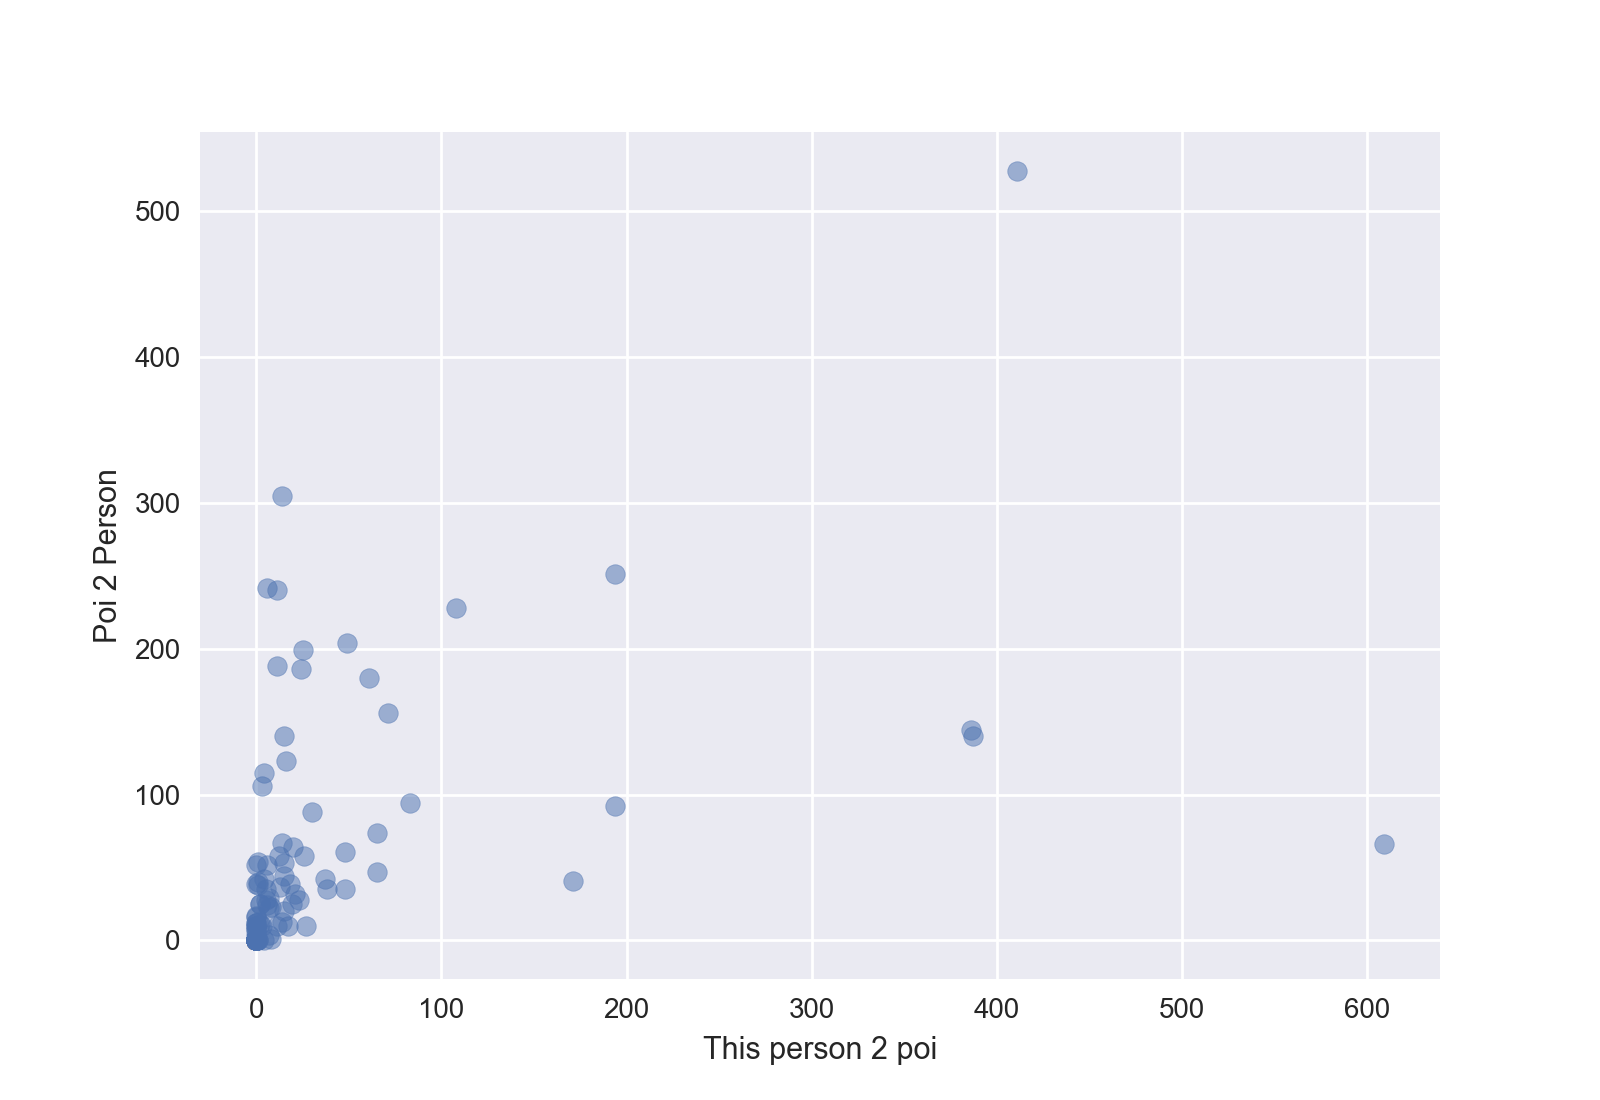

In [18]:
plt.scatter(df['from_this_person_to_poi'], df['from_poi_to_this_person'], alpha=.5, edgecolors='face')
plt.xlabel("This person 2 poi")
plt.ylabel("Poi 2 Person")
plt.show()

In [19]:
from_poi_outliers = []
for k , v in zip(df.index, df['from_poi_to_this_person']):
    from_poi_outliers.append((k,v))
sorted(from_poi_outliers,key=lambda x:x[1],reverse=True)[:6]

[('LAVORATO JOHN J', 528.0),
 ('DIETRICH JANET R', 305.0),
 ('KITCHEN LOUISE', 251.0),
 ('FREVERT MARK A', 242.0),
 ('COLWELL WESLEY', 240.0),
 ('BELDEN TIMOTHY N', 228.0)]

In [20]:
to_poi_outliers = []
for k , v in zip(df.index, df['from_this_person_to_poi']):
    to_poi_outliers.append((k,v))
sorted(to_poi_outliers,key=lambda x:x[1],reverse=True)[:6]

[('DELAINEY DAVID W', 609.0),
 ('LAVORATO JOHN J', 411.0),
 ('KEAN STEVEN J', 387.0),
 ('BECK SALLY W', 386.0),
 ('KITCHEN LOUISE', 194.0),
 ('MCCONNELL MICHAEL S', 194.0)]

#### 移除過多遺失值Feature，檢視箱形圖

In [21]:
 flt_col = ['bonus', 'exercised_stock_options', 'expenses','from_messages', 'from_poi_to_this_person',
       'from_this_person_to_poi', 'other', 'restricted_stock','salary', 'shared_receipt_with_poi', 'to_messages','total_payments', 'total_stock_value']

<IPython.core.display.Javascript object>


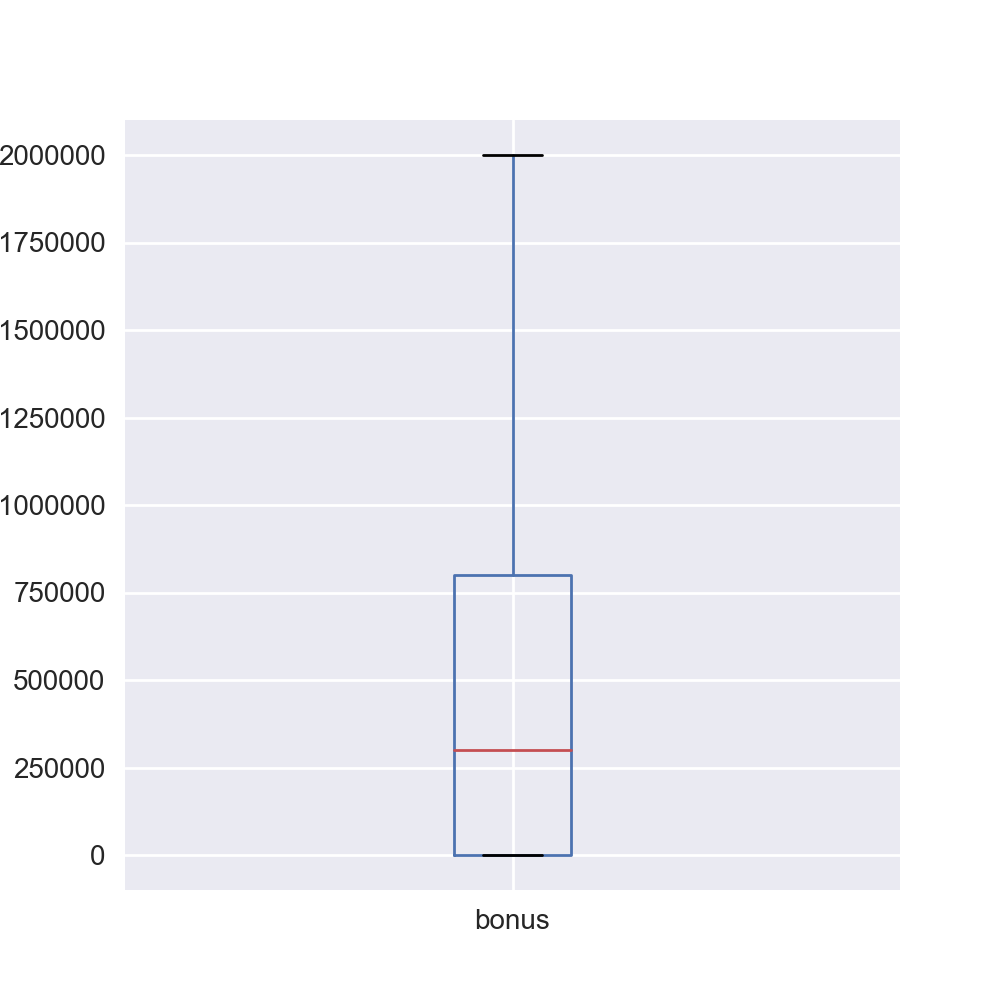

<IPython.core.display.Javascript object>


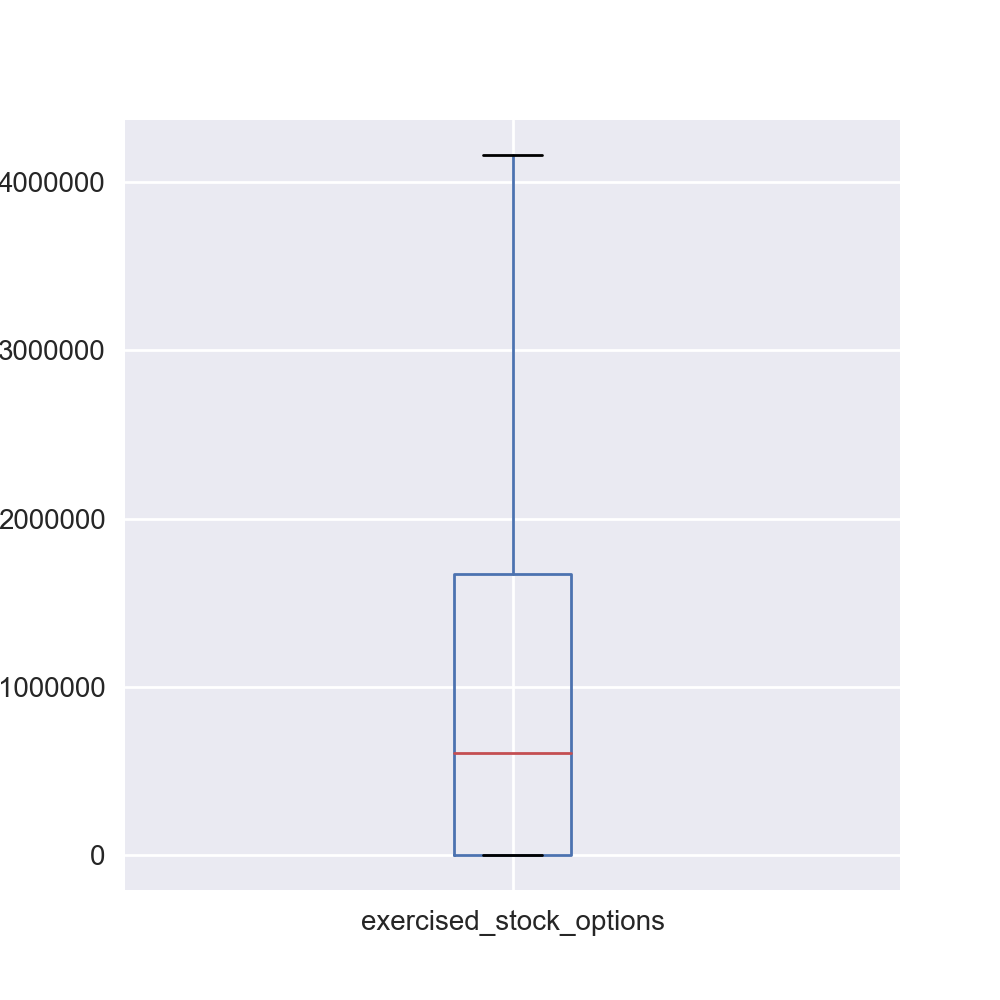

<IPython.core.display.Javascript object>


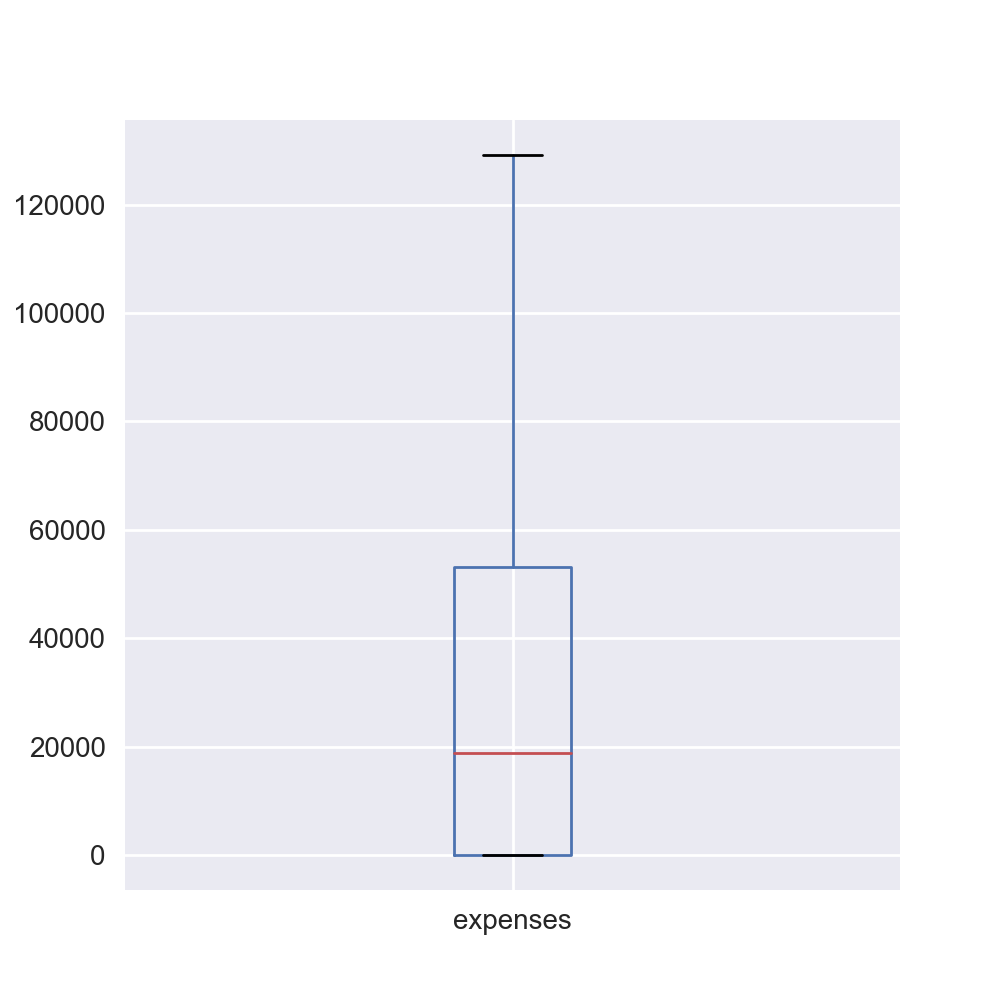

<IPython.core.display.Javascript object>


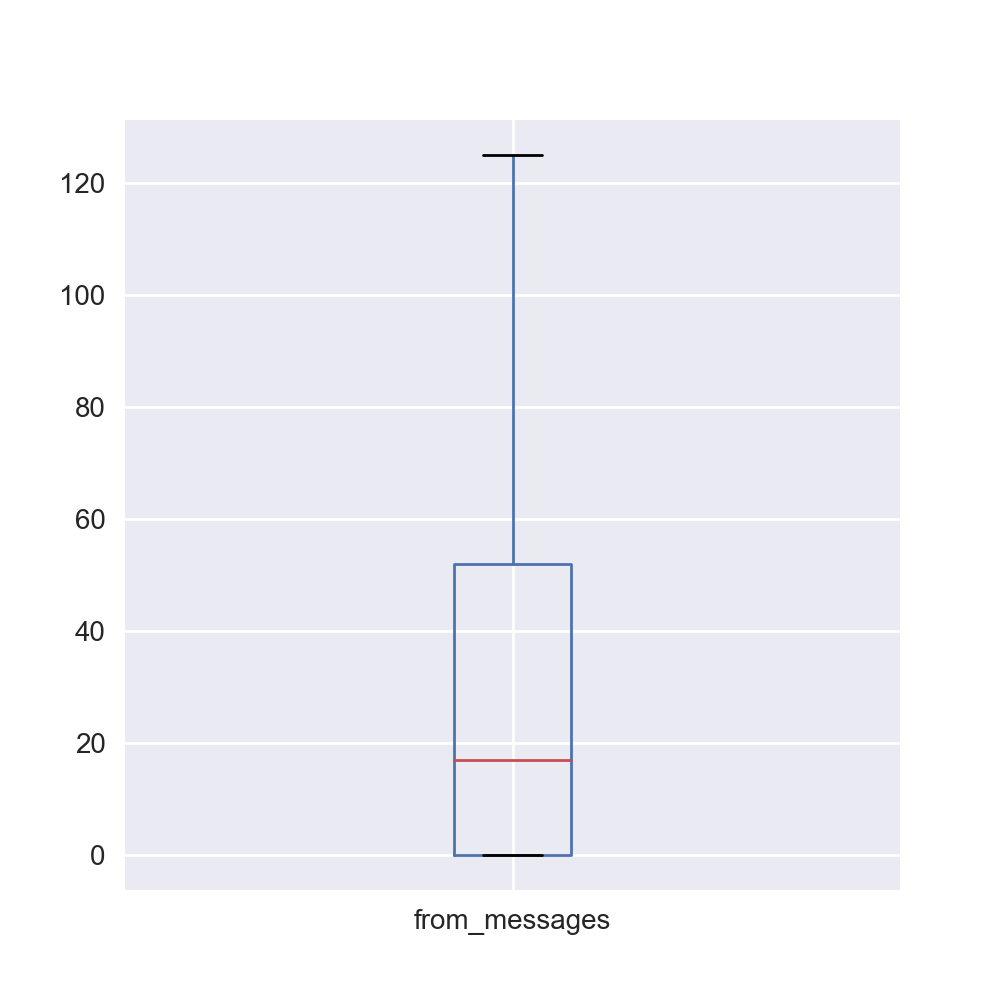

<IPython.core.display.Javascript object>


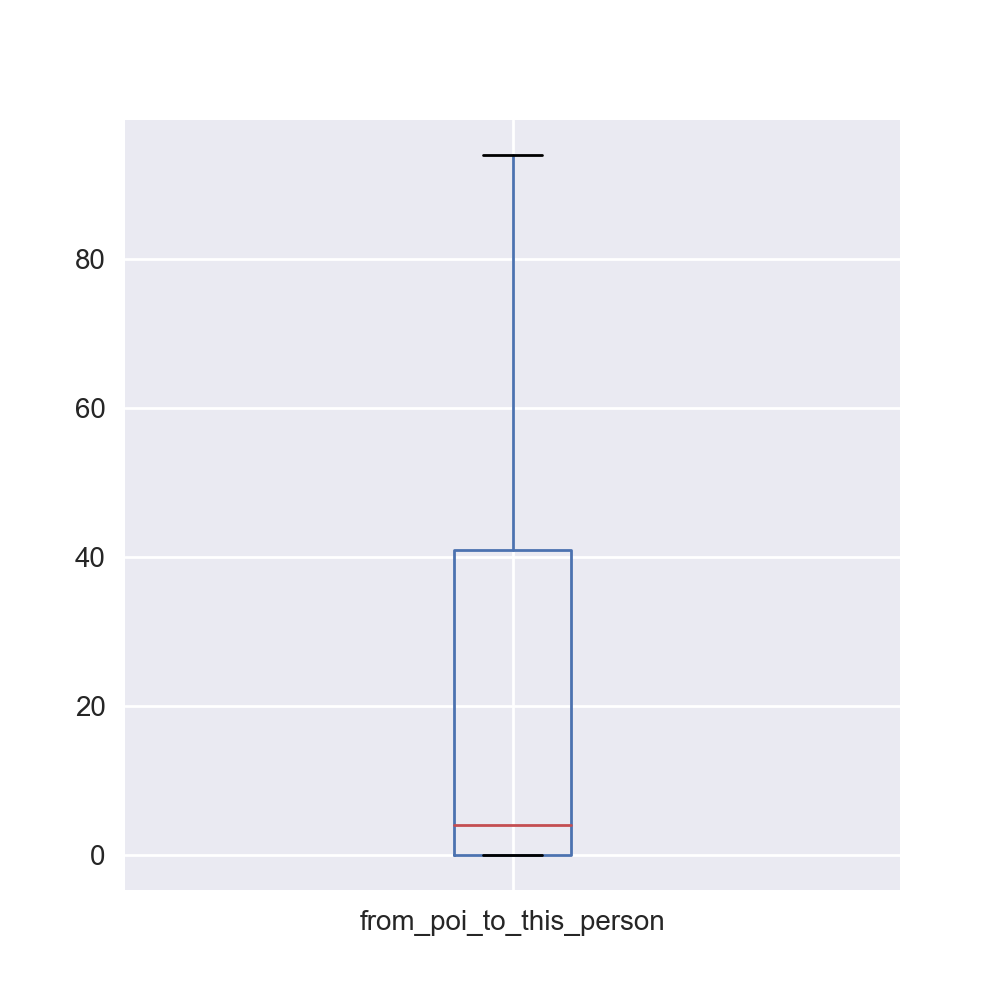

<IPython.core.display.Javascript object>


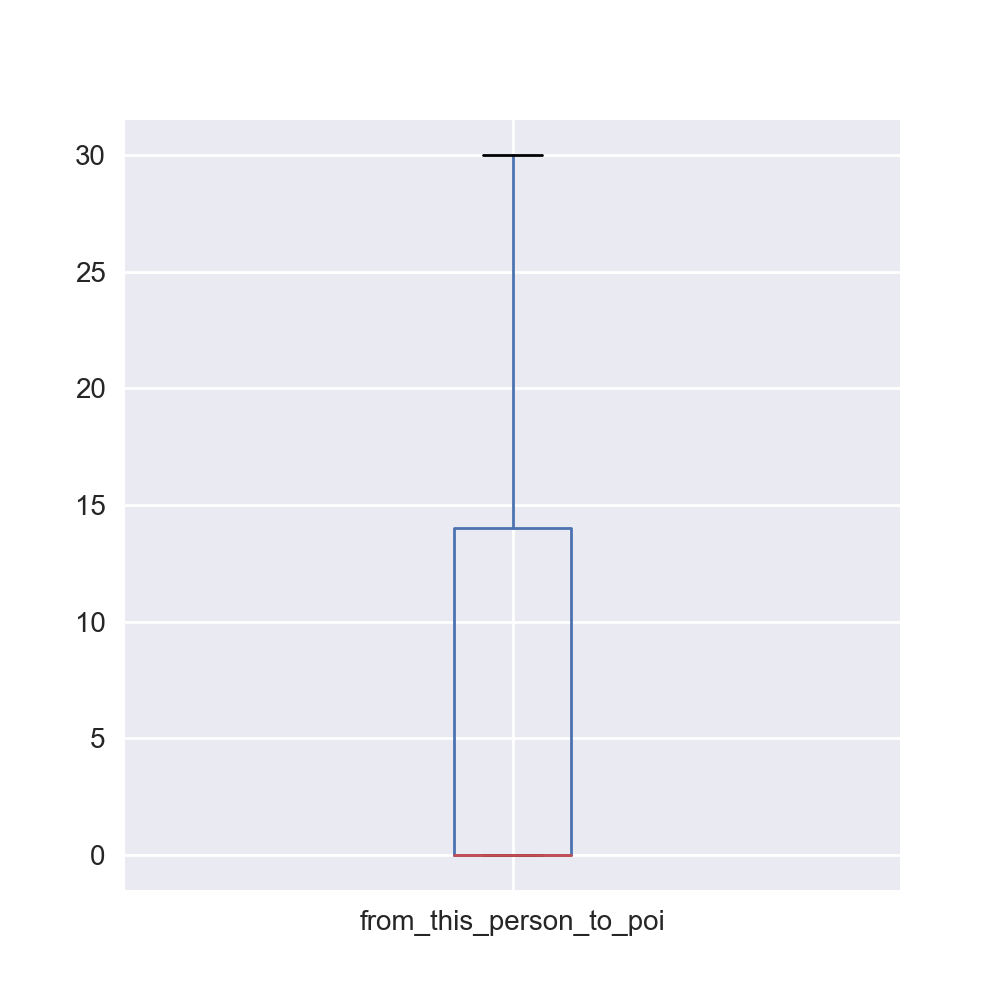

<IPython.core.display.Javascript object>


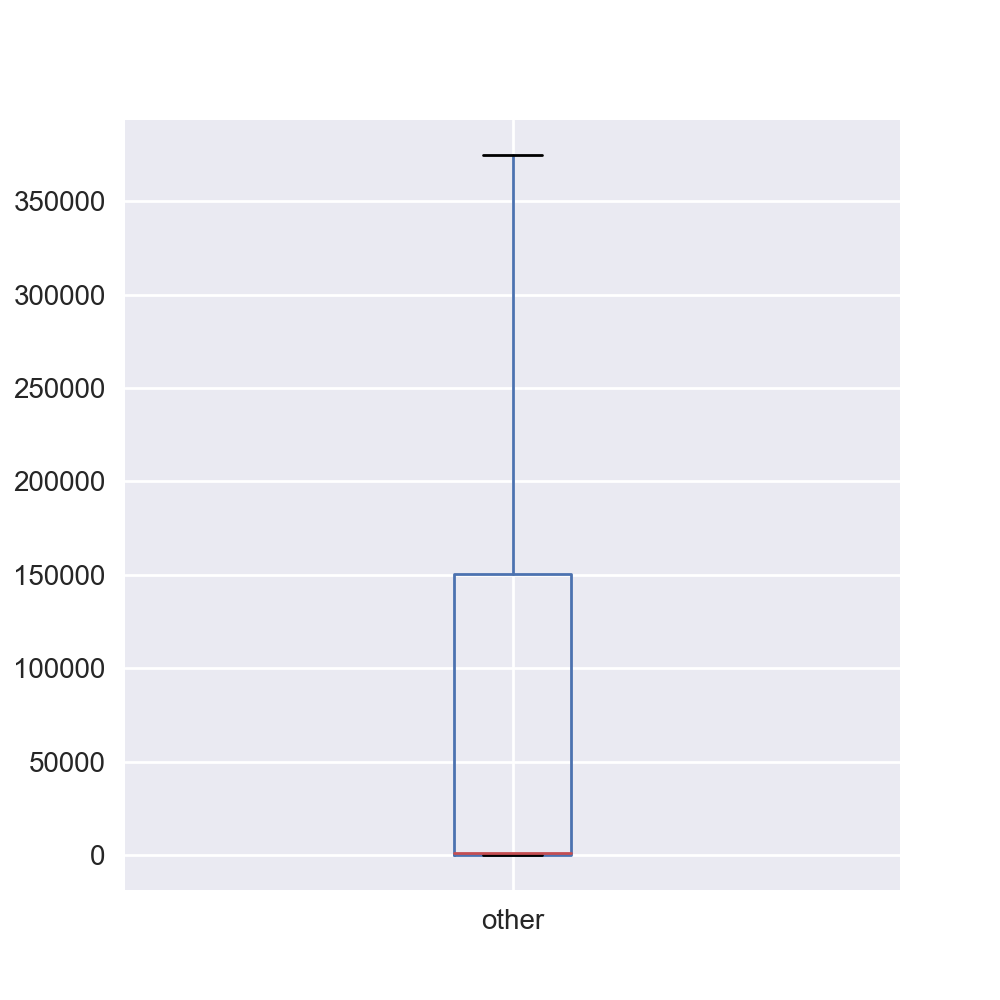

<IPython.core.display.Javascript object>


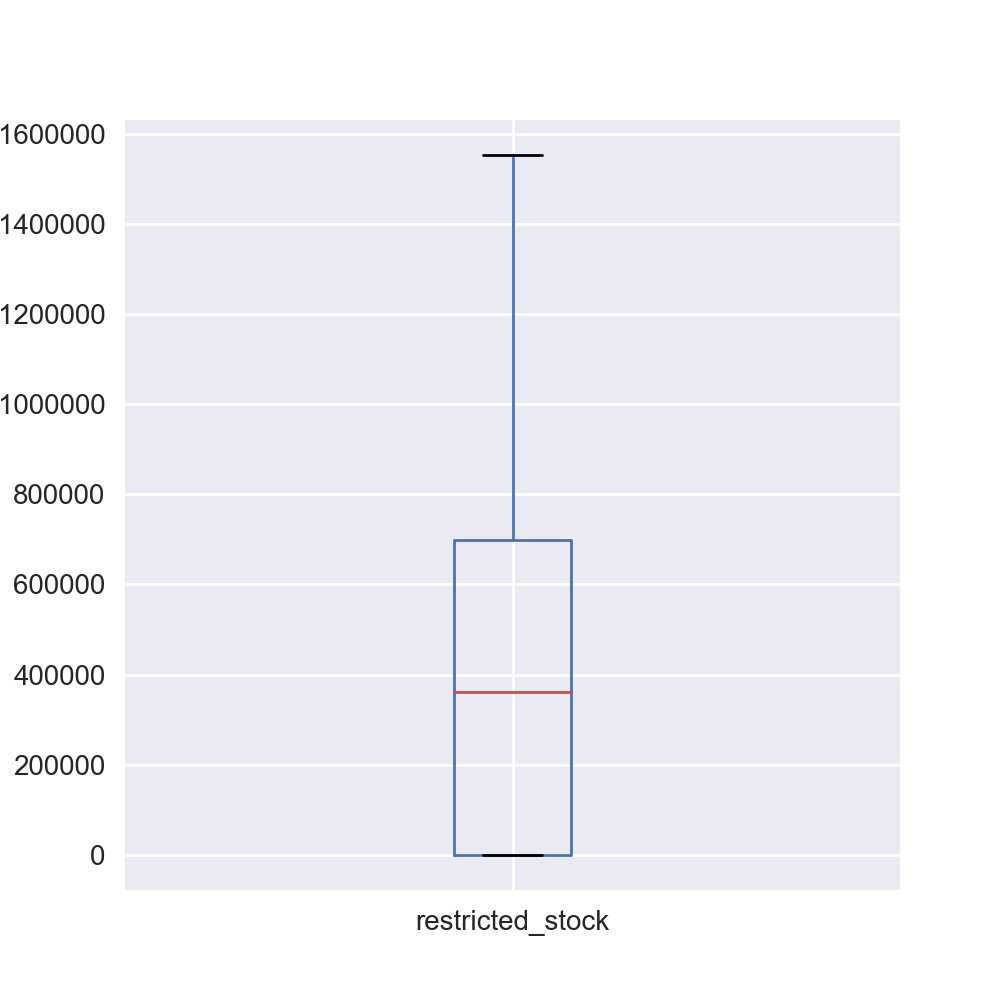

<IPython.core.display.Javascript object>


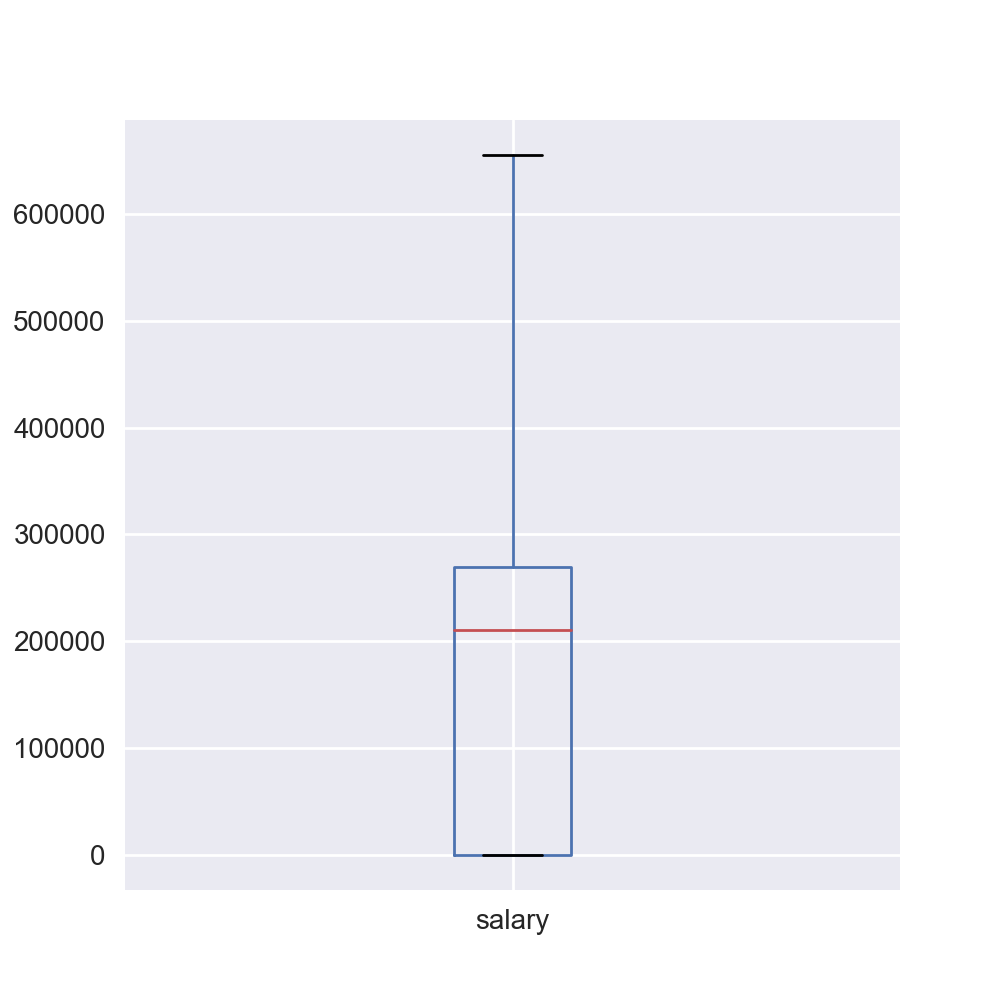

<IPython.core.display.Javascript object>


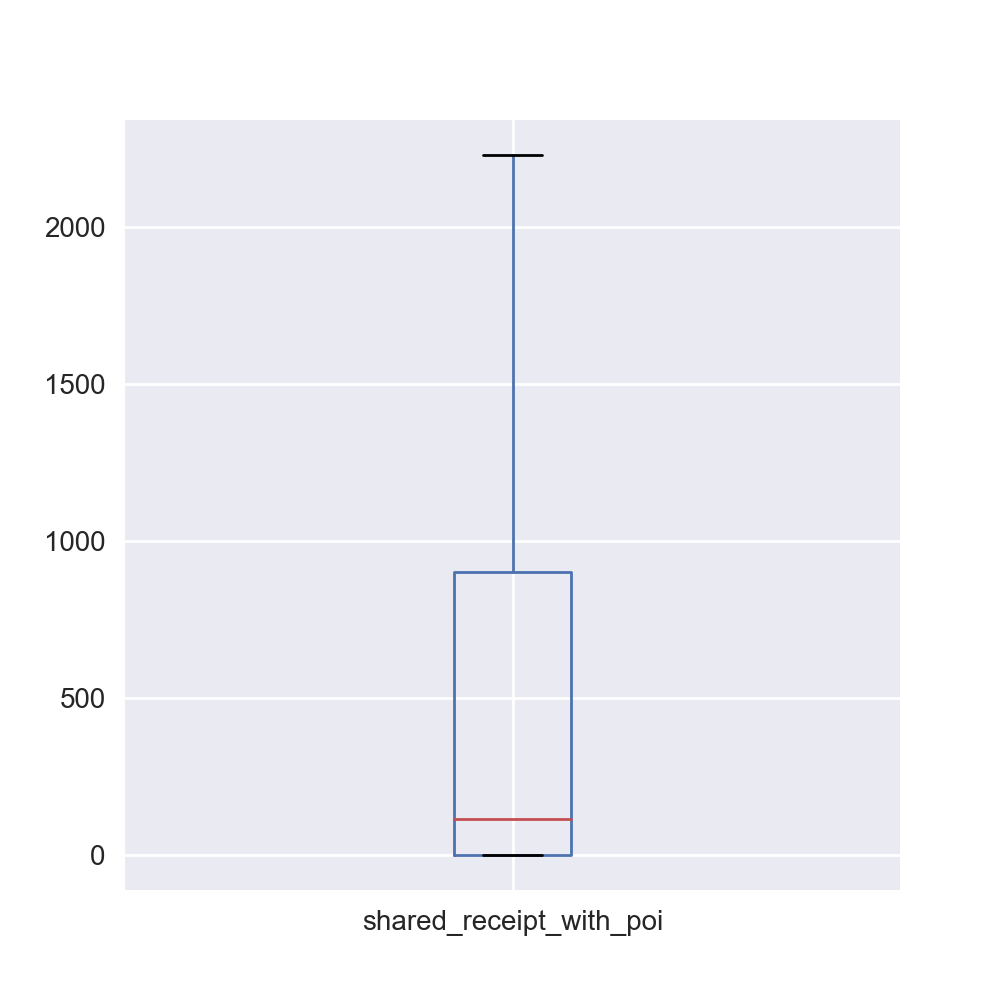

<IPython.core.display.Javascript object>


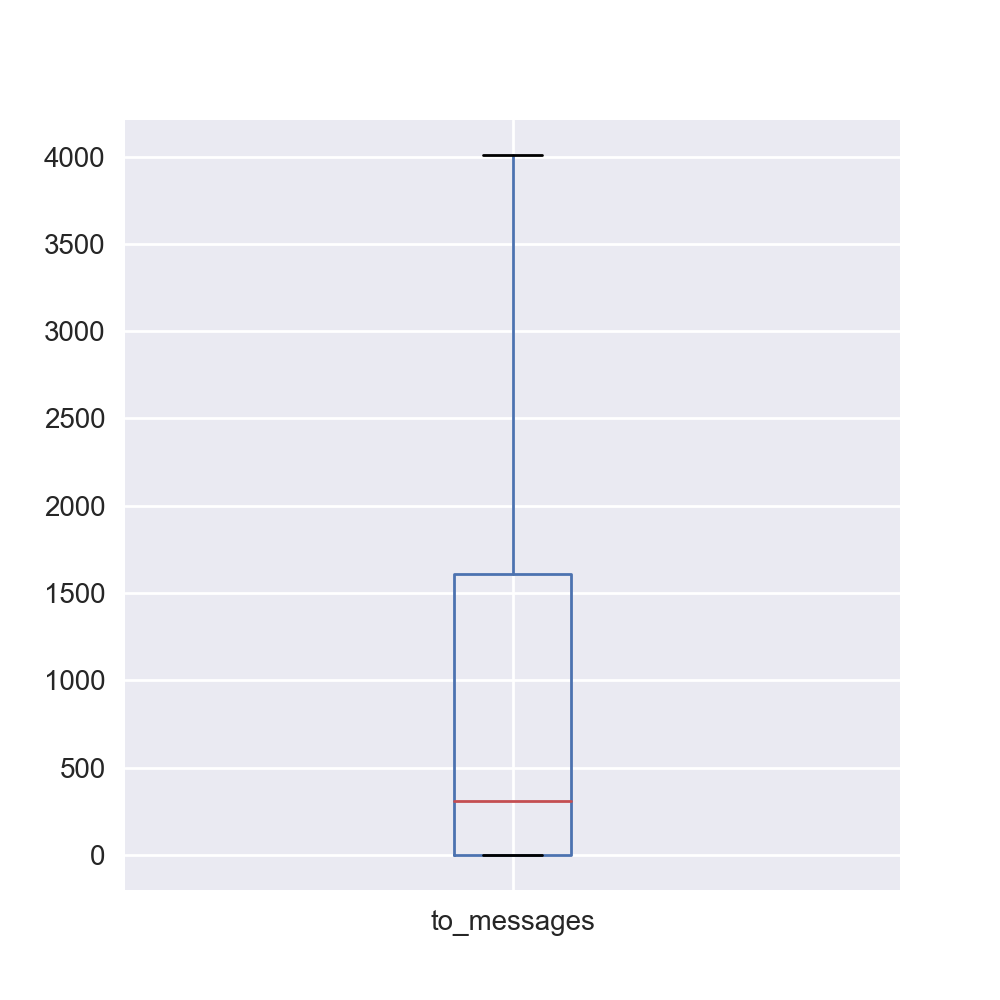

<IPython.core.display.Javascript object>


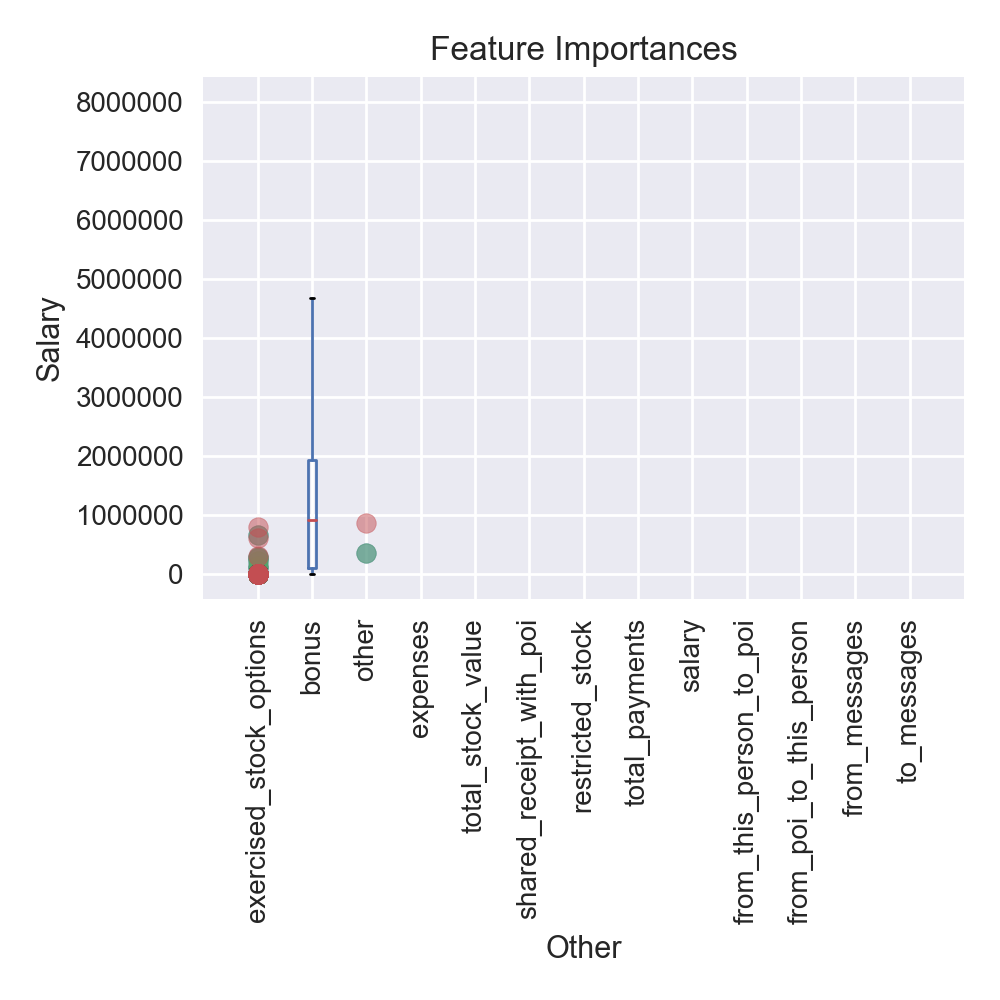

<IPython.core.display.Javascript object>


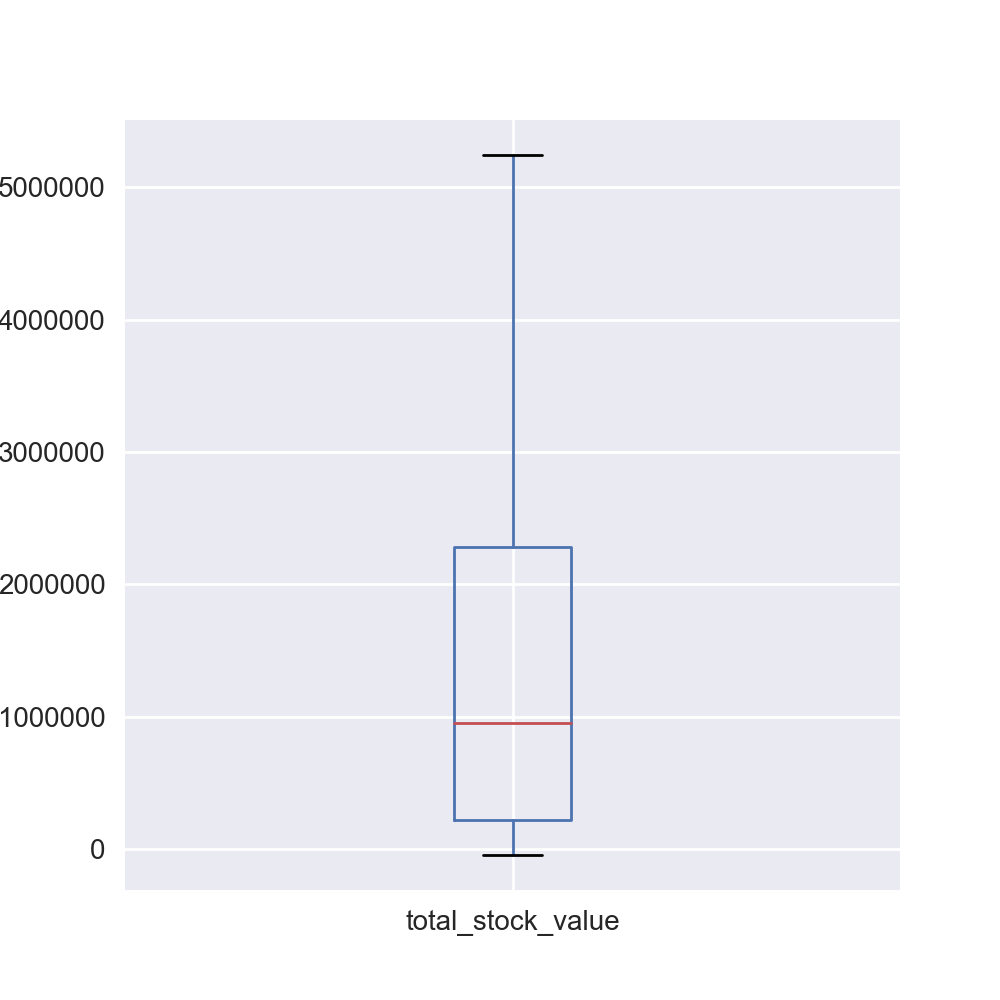

In [53]:
for i in flt_col:
    fig, ax = plt.subplots(figsize=(5, 5))
    df.boxplot(i, showfliers=False)
    #sns.boxplot(i, data=df)
    #sns.stripplot(i, data=df, jitter=True);
    plt.show()

#### 由圖得知，财务特征 **other** 異常值過度懸殊

In [57]:
other_outliers = []
for k , v in zip(df.index, df['other']):
    other_outliers.append((k,v))
sorted(other_outliers,key=lambda x:x[1],reverse=True)[:20]

[('LAY KENNETH L', 10359729.0),
 ('FREVERT MARK A', 7427621.0),
 ('MARTIN AMANDA K', 2818454.0),
 ('BAXTER JOHN C', 2660303.0),
 ('SHERRIFF JOHN R', 1852186.0),
 ('PAI LOU L', 1829457.0),
 ('SHELBY REX', 1573324.0),
 ('IZZO LAWRENCE L', 1553729.0),
 ('WHITE JR THOMAS E', 1085463.0),
 ('KOPPER MICHAEL J', 907502.0),
 ('BANNANTINE JAMES M', 864523.0),
 ('GOLD JOSEPH', 819288.0),
 ('GRAY RODNEY', 680833.0),
 ('KISHKILL JOSEPH G', 465357.0),
 ('BERGSIEKER RICHARD P', 427316.0),
 ('THORN TERENCE H', 426629.0),
 ('BIBI PHILIPPE A', 425688.0),
 ('HERMANN ROBERT J', 416441.0),
 ('FALLON JAMES B', 401481.0),
 ('WESTFAHL RICHARD K', 401130.0)]

- 董事長 LAY KENNETH L 從other财务，收入達八位數字。
- 副董事 FREVERT MARK A 位居第二

### 檢視個體存在最多的缺失值
- NaN已經被轉成0，所以檢視最多的0值個體
- 有可能本身數據就已經是0

In [52]:
from collections import defaultdict
info = defaultdict(list)
for i in df.index:
    info[i] = 0
    for j in range(0, len(df.columns)):
        if df.loc[i][j] == 0:            
            info[i] += 1
sorted(info.items(), key=lambda x:x[1], reverse = True)[:20]

[('LOCKHART EUGENE E', 20),
 ('WODRASKA JOHN', 18),
 ('WHALEY DAVID A', 18),
 ('WROBEL BRUCE', 18),
 ('SCRIMSHAW MATTHEW', 18),
 ('THE TRAVEL AGENCY IN THE PARK', 18),
 ('GRAMM WENDY L', 18),
 ('CLINE KENNETH W', 17),
 ('WAKEHAM JOHN', 17),
 ('GILLIS JOHN', 17),
 ('CHRISTODOULOU DIOMEDES', 17),
 ('SAVAGE FRANK', 17),
 ('LOWRY CHARLES P', 16),
 ('CHAN RONNIE', 16),
 ('URQUHART JOHN A', 16),
 ('MENDELSOHN JOHN', 16),
 ('MEYER JEROME J', 16),
 ('GATHMANN WILLIAM D', 16),
 ('PEREIRA PAULO V. FERRAZ', 16),
 ('BLAKE JR. NORMAN P', 16)]

### 'THE TRAVEL AGENCY IN THE PARK'，不屬於個體，刪除此欄位。


In [11]:
df = df.drop('THE TRAVEL AGENCY IN THE PARK')

## 优化特征选择/工程
1. 创建新特征
    - 测试了该特征对最终算法性能的影响。
    - 未要求学生将新特征包含在其最终特征集内。
2. 明智地选择特征
    - 尝试了不同的特征组合，并记录了每种组合的性能
3. 适当缩放特征
    - 若算法要求缩放的特征，则部署特征缩放。

### 创建新特征

- 檢視，薪資，獎金以外的特徵，把它平方，強大差異效應，再取對數，把數據縮小

In [12]:
df['extra_payment_std'] = np.log10((df['total_payments'] -df['bonus'] - df['salary']+0.0001)**2)

### 找出最大特徵向量當作，新特徵
- PCA: 線性壓縮，透過ＳＶＤ分解，依據變異量大小當作特徵向量
- ICA: 找出彼此獨立的特徵向量
- KernelPCA: 非線性壓縮

In [14]:
n_comp = 4

# ICA
ica = FastICA(n_components=n_comp, random_state=None)
ica_results = ica.fit_transform(df)

# kPCA
kpca = KernelPCA(n_components=n_comp,kernel='rbf', random_state=None)
kca_results = ica.fit_transform(df)

# PCA
pca = PCA(n_components=n_comp, random_state=None)
pca_results = pca.fit_transform(df)

In [15]:
for i in range(1, n_comp + 1):
    df['pca_' + str(i)] = pca_results[:,i-1]    
    df['ica_' + str(i)] = ica_results[:,i-1]
    df['kca_' + str(i)] = kca_results[:,i-1]


### 选择特征 / 特徵縮放


- 特徵縮放

In [16]:
features_list = df.drop('poi', axis = 1).columns.values
X_train = df[features_list]
y_train = df.poi.values

In [17]:

Stand = StandardScaler()
MinMax = MinMaxScaler()
X_train = MinMax.fit_transform(X_train)

<IPython.core.display.Javascript object>


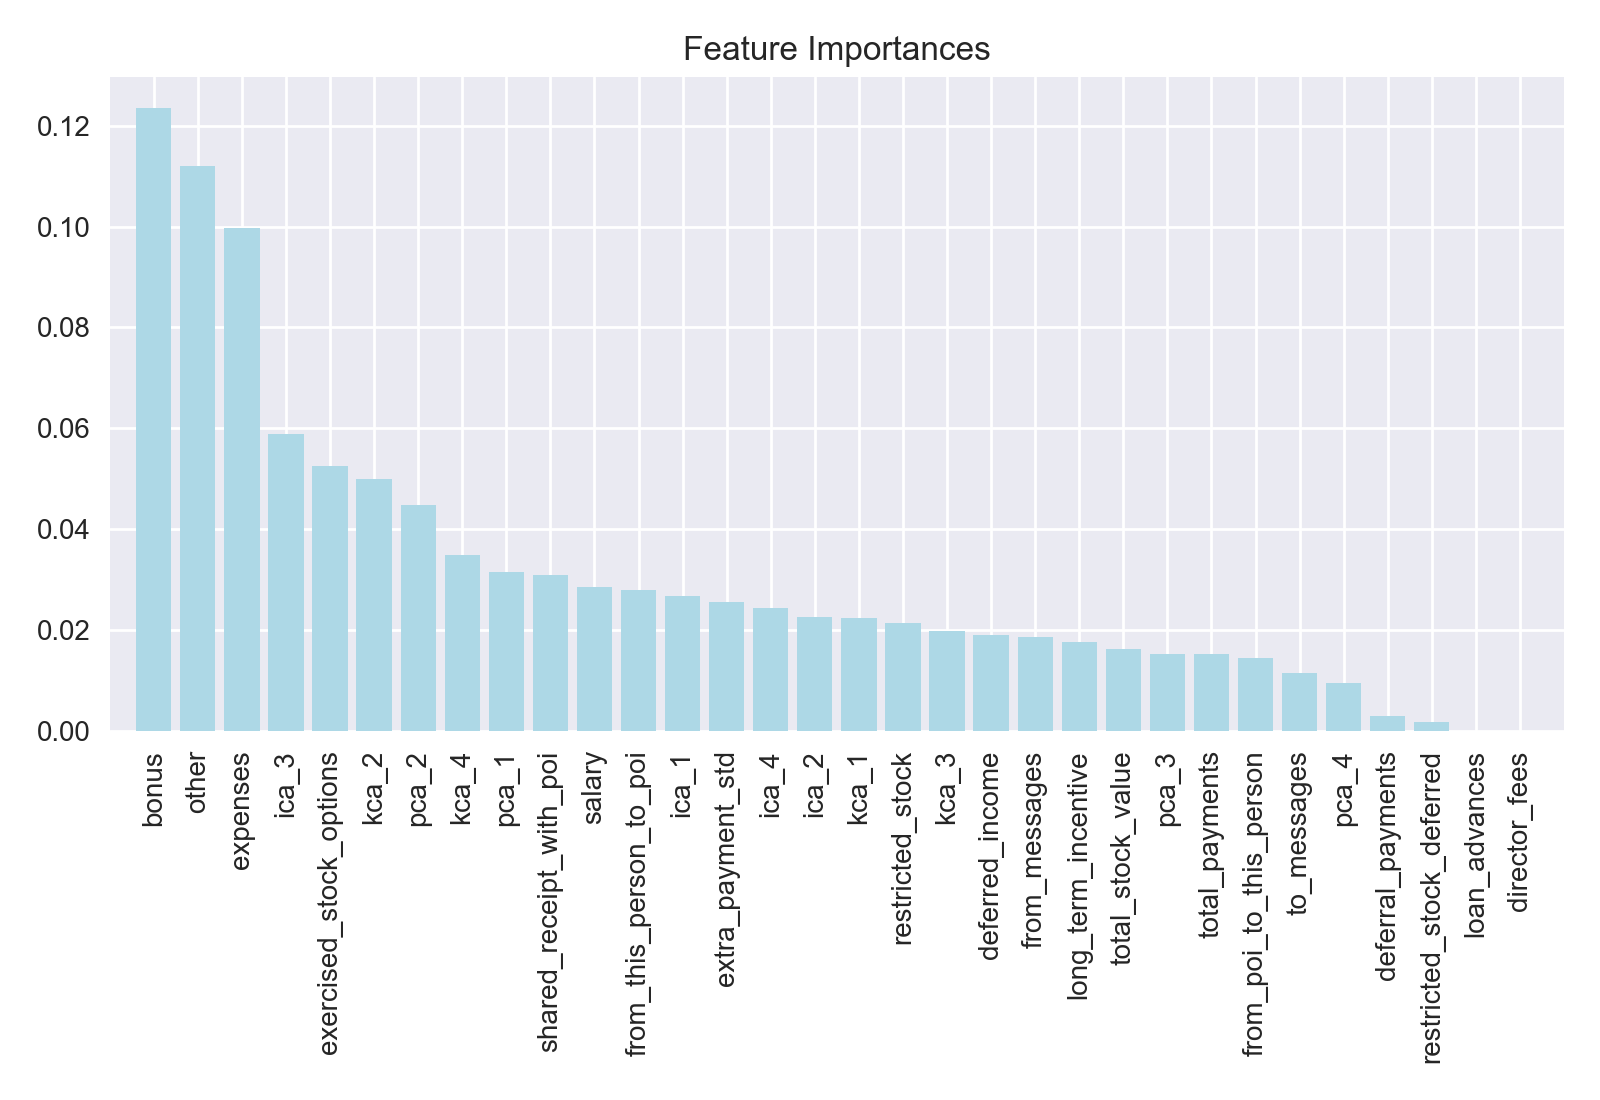

In [18]:

feat_labels = df[features_list].columns

forest = RandomForestClassifier(n_estimators=100,
                                criterion = 'entropy',
                                max_features = None,
                                max_depth = 5,
                                random_state=None,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

###  樣本數少，為了避免Overfitting，先取前20個特徵值

In [22]:
list(feat_labels[indices])[:-15]

['expenses',
 'other',
 'bonus',
 'pca_2',
 'exercised_stock_options',
 'pca_1',
 'from_this_person_to_poi',
 'kca_1',
 'pca_3',
 'kca_4',
 'ica_4',
 'shared_receipt_with_poi',
 'total_stock_value',
 'salary',
 'extra_payment_std',
 'from_poi_to_this_person',
 'deferred_income']

In [19]:
Features = list(feat_labels[indices])[:-15]
X_train = df[Features]
print('Total Importance Features : %d'%(len(Features)))

Total Importance Features : 17


## 选择和调整算法
1. 选择算法
2. 参数调整
3. 调整算法
    - 使用 GridSearchCV 进行参数调整
    - 调整了多个参数
    - 参数调整融入了算法部分

## 验证和评估
1. 评估度量的使用
    - 至少使用了两个适当度量来评估算法性能
2. 验证及其重要性
    - 回复解决了什么是验证以及它的重要性
3. 验证策略
    - 将数据拆分为培训和测试集或使用交叉验证，并说明所执行验证的具体类型。
4. 算法性能
    - 精确度、召回率均至少为 0.3。

### 選擇算法

In [20]:

ADA_clf = AdaBoostClassifier()
RF_clf = RandomForestClassifier()
GB_clf = GradientBoostingClassifier()
SVC_clf = SVC()

### 验证策略
- 把數據拆開，訓練/測試

In [21]:

Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size = 0.2, random_state = None)
MinMax = MinMaxScaler()
Xtrain = MinMax.fit_transform(Xtrain)
Xtest = MinMax.fit_transform(Xtest)

### 未調參之前，模型表現
- 比較 訓練/測試 accuracy_score 的表現，判斷是否overfitting
- Recall - Precision curve
- Roc Curve

<IPython.core.display.Javascript object>


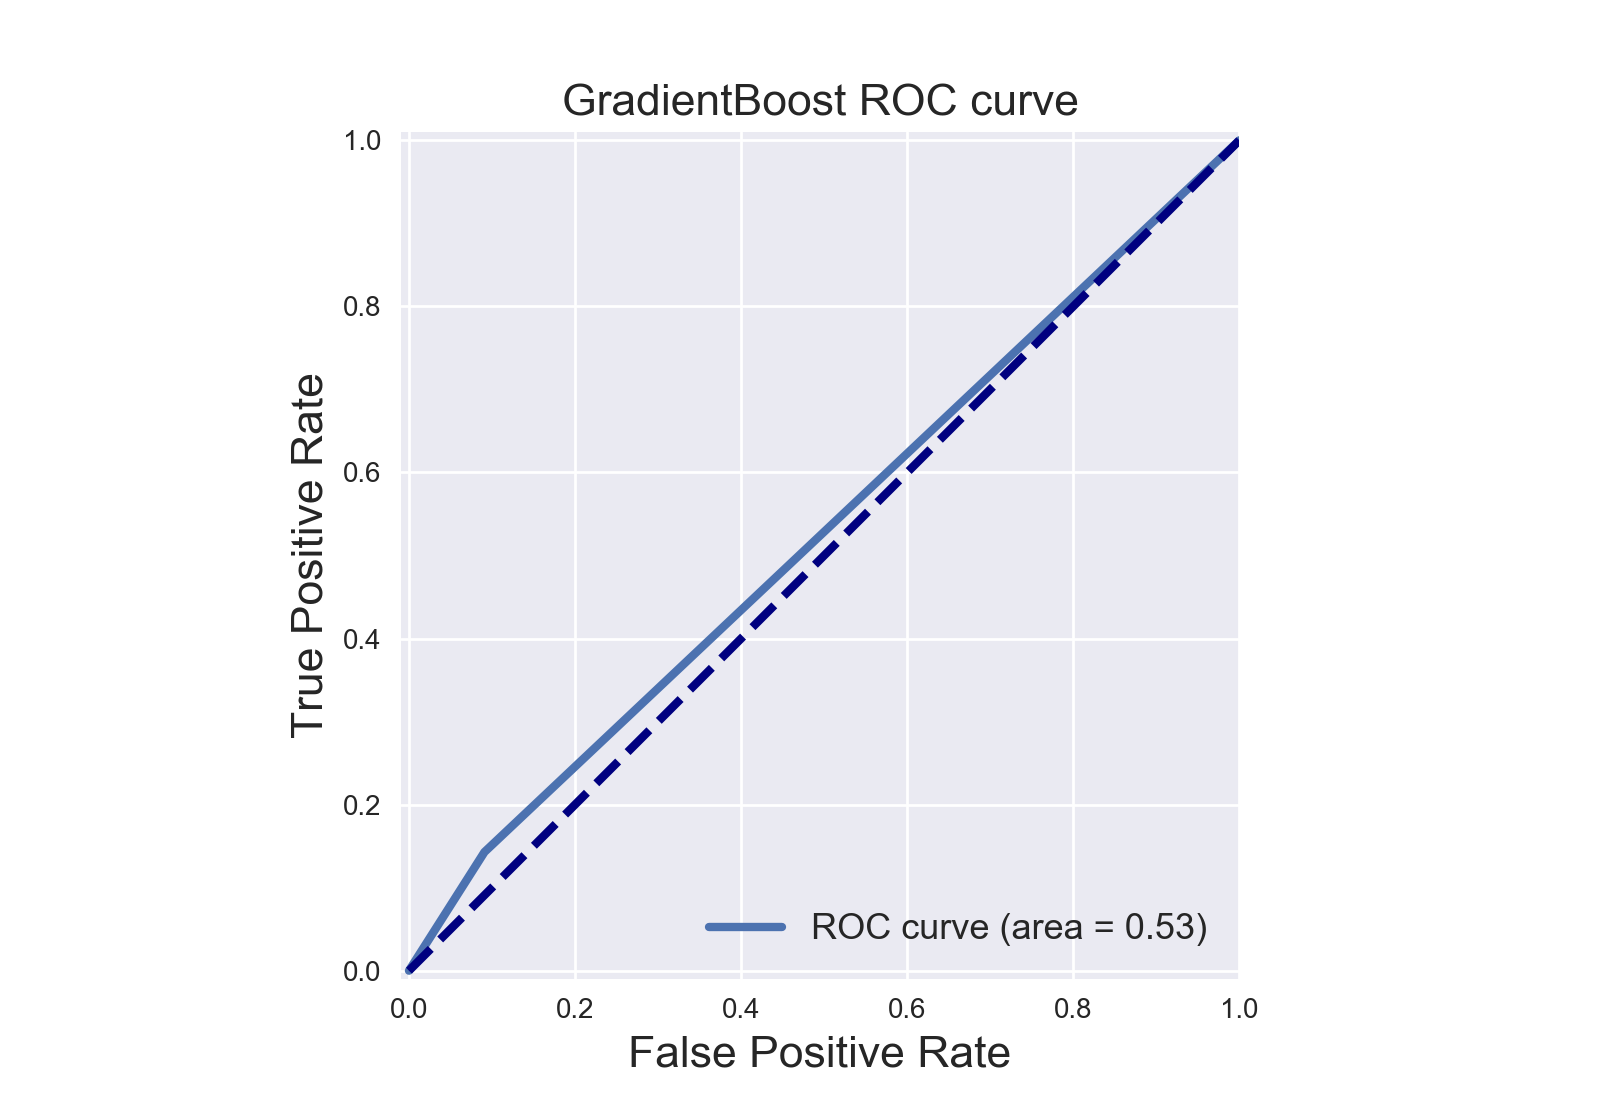

<IPython.core.display.Javascript object>


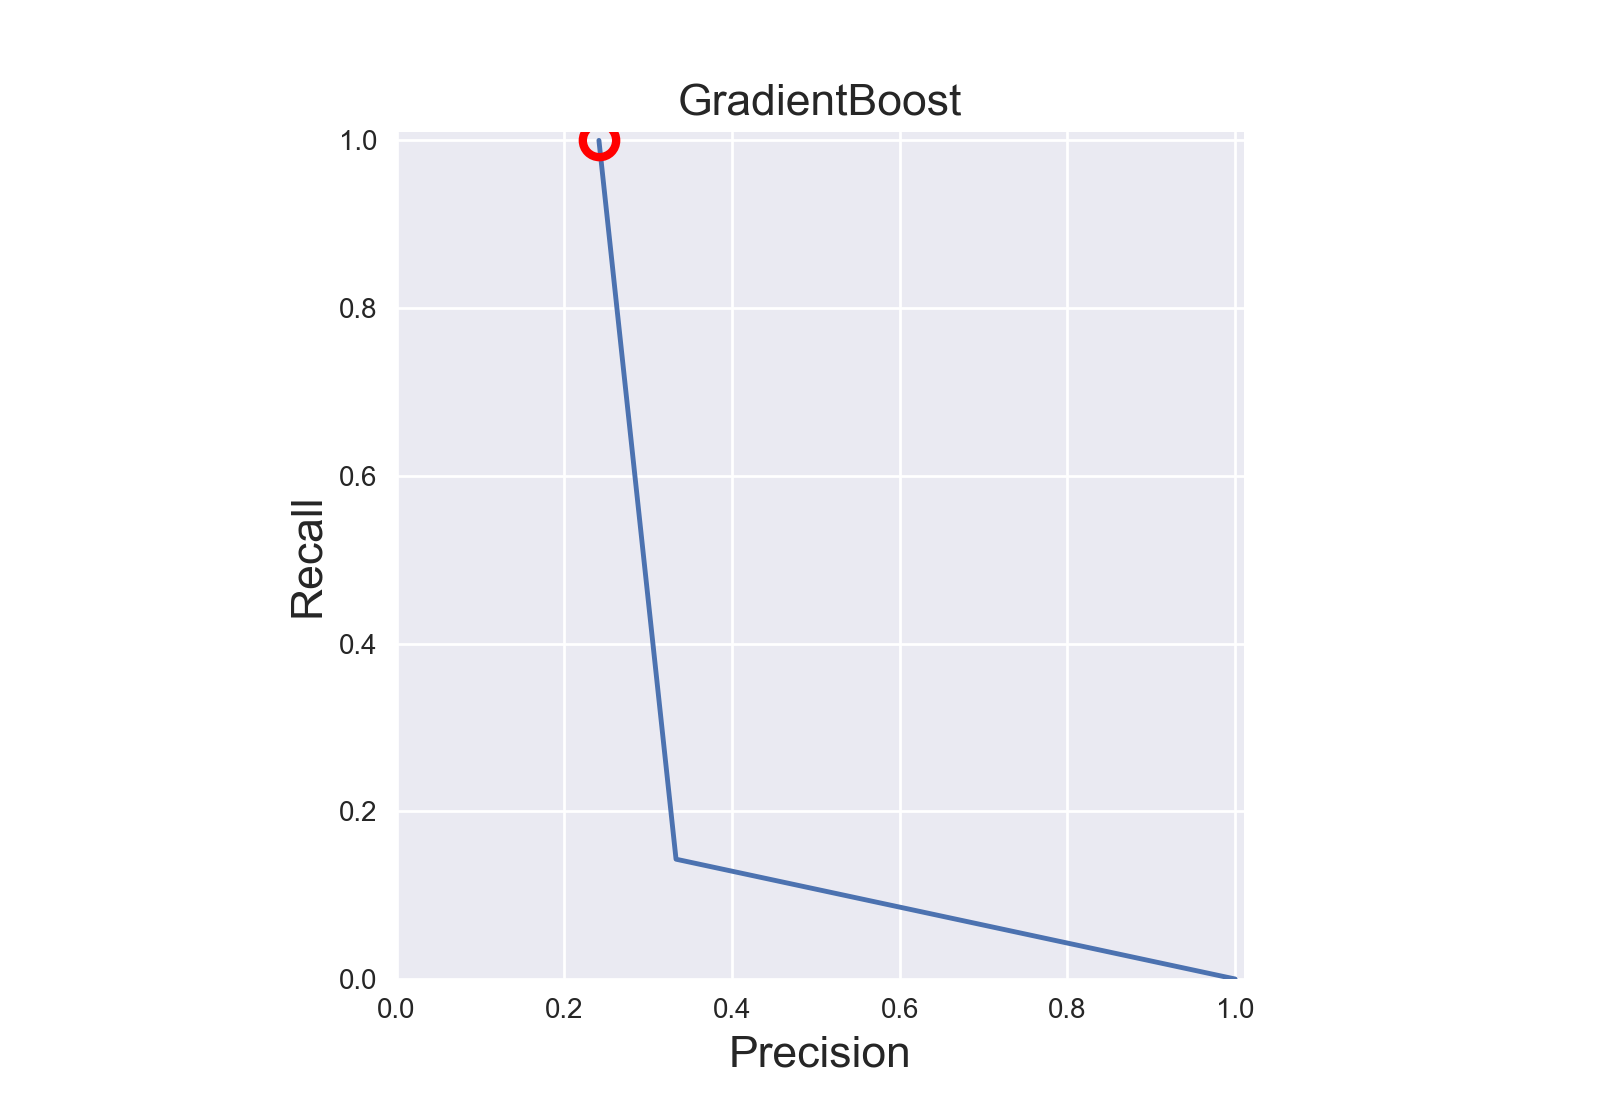

GradientBoost 
             precision    recall  f1-score   support

          0       0.77      0.91      0.83        22
          1       0.33      0.14      0.20         7

avg / total       0.66      0.72      0.68        29



<IPython.core.display.Javascript object>


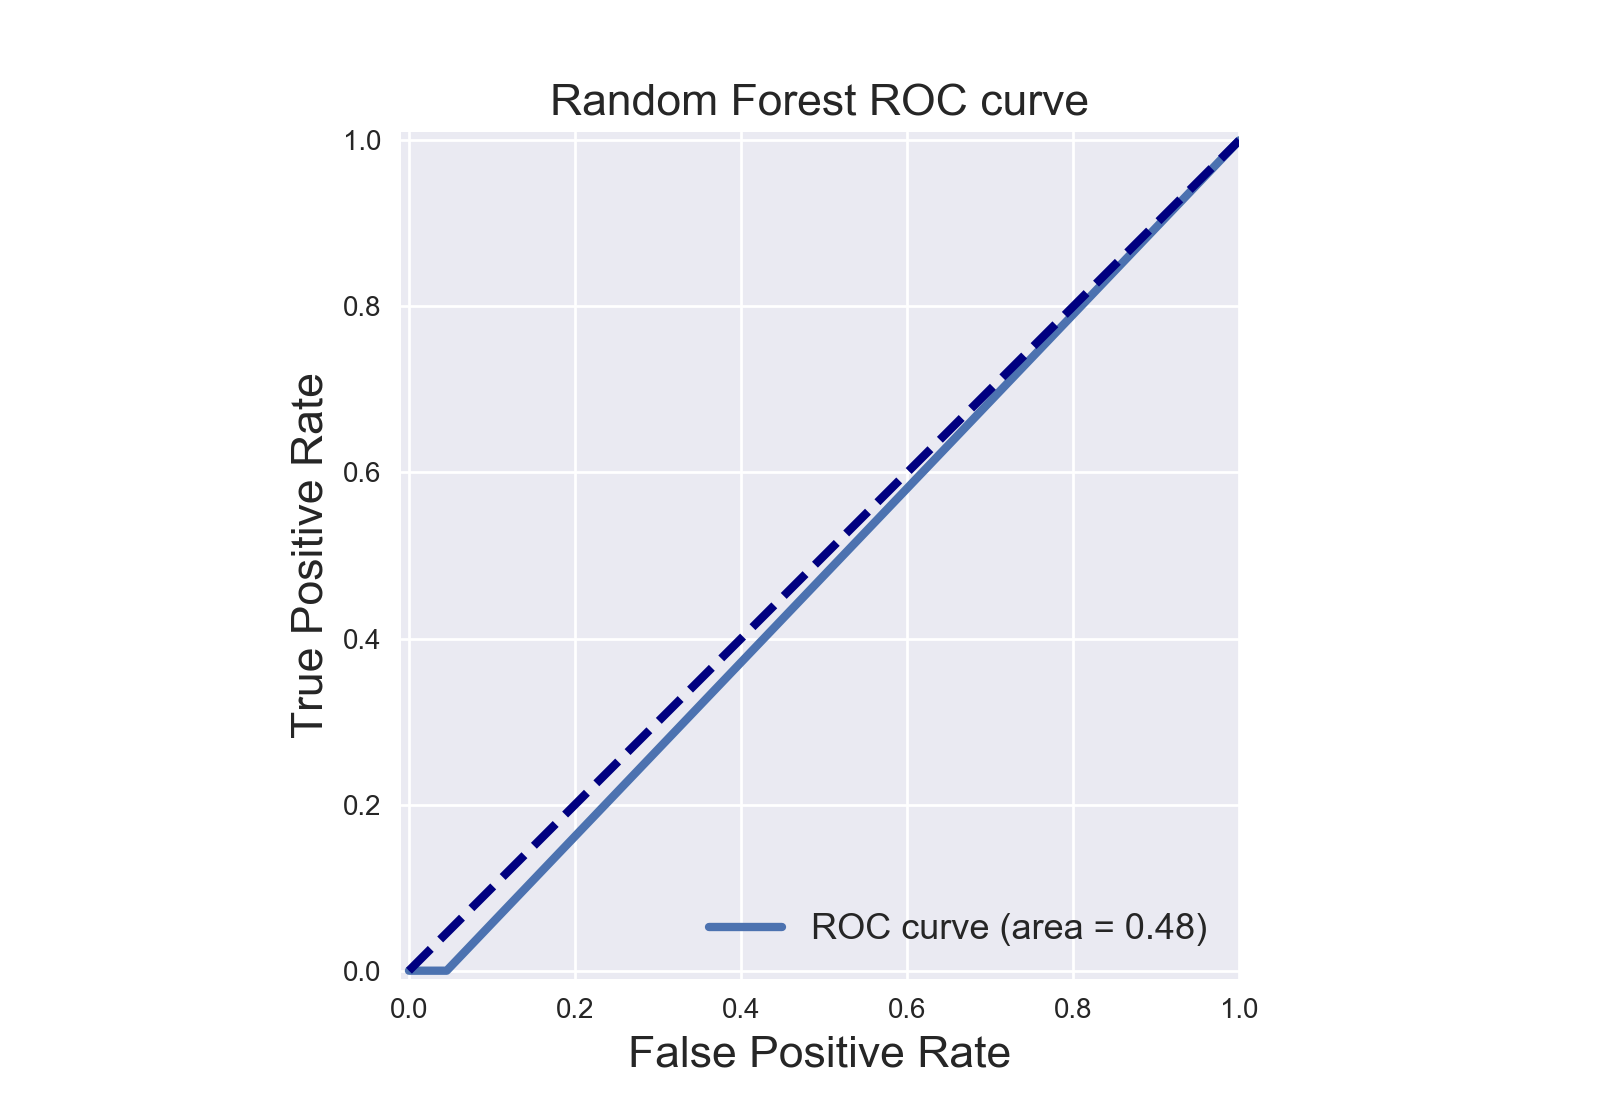

<IPython.core.display.Javascript object>


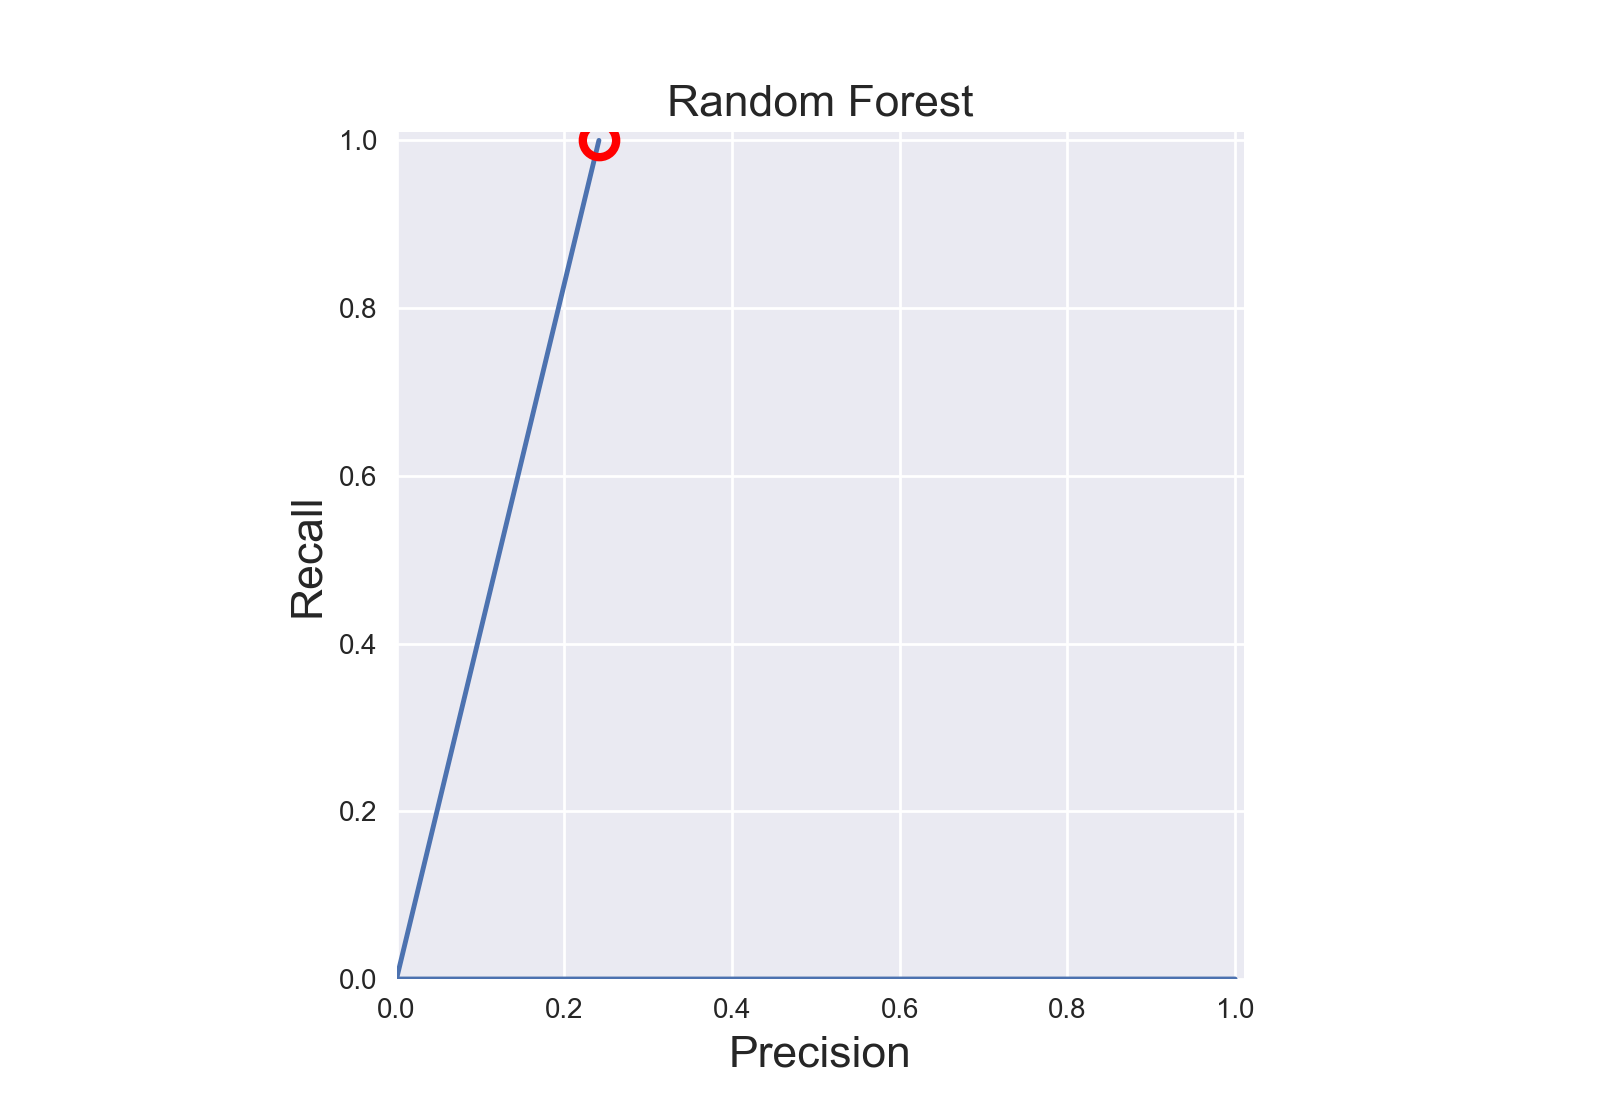

Random Forest 
             precision    recall  f1-score   support

          0       0.75      0.95      0.84        22
          1       0.00      0.00      0.00         7

avg / total       0.57      0.72      0.64        29



<IPython.core.display.Javascript object>


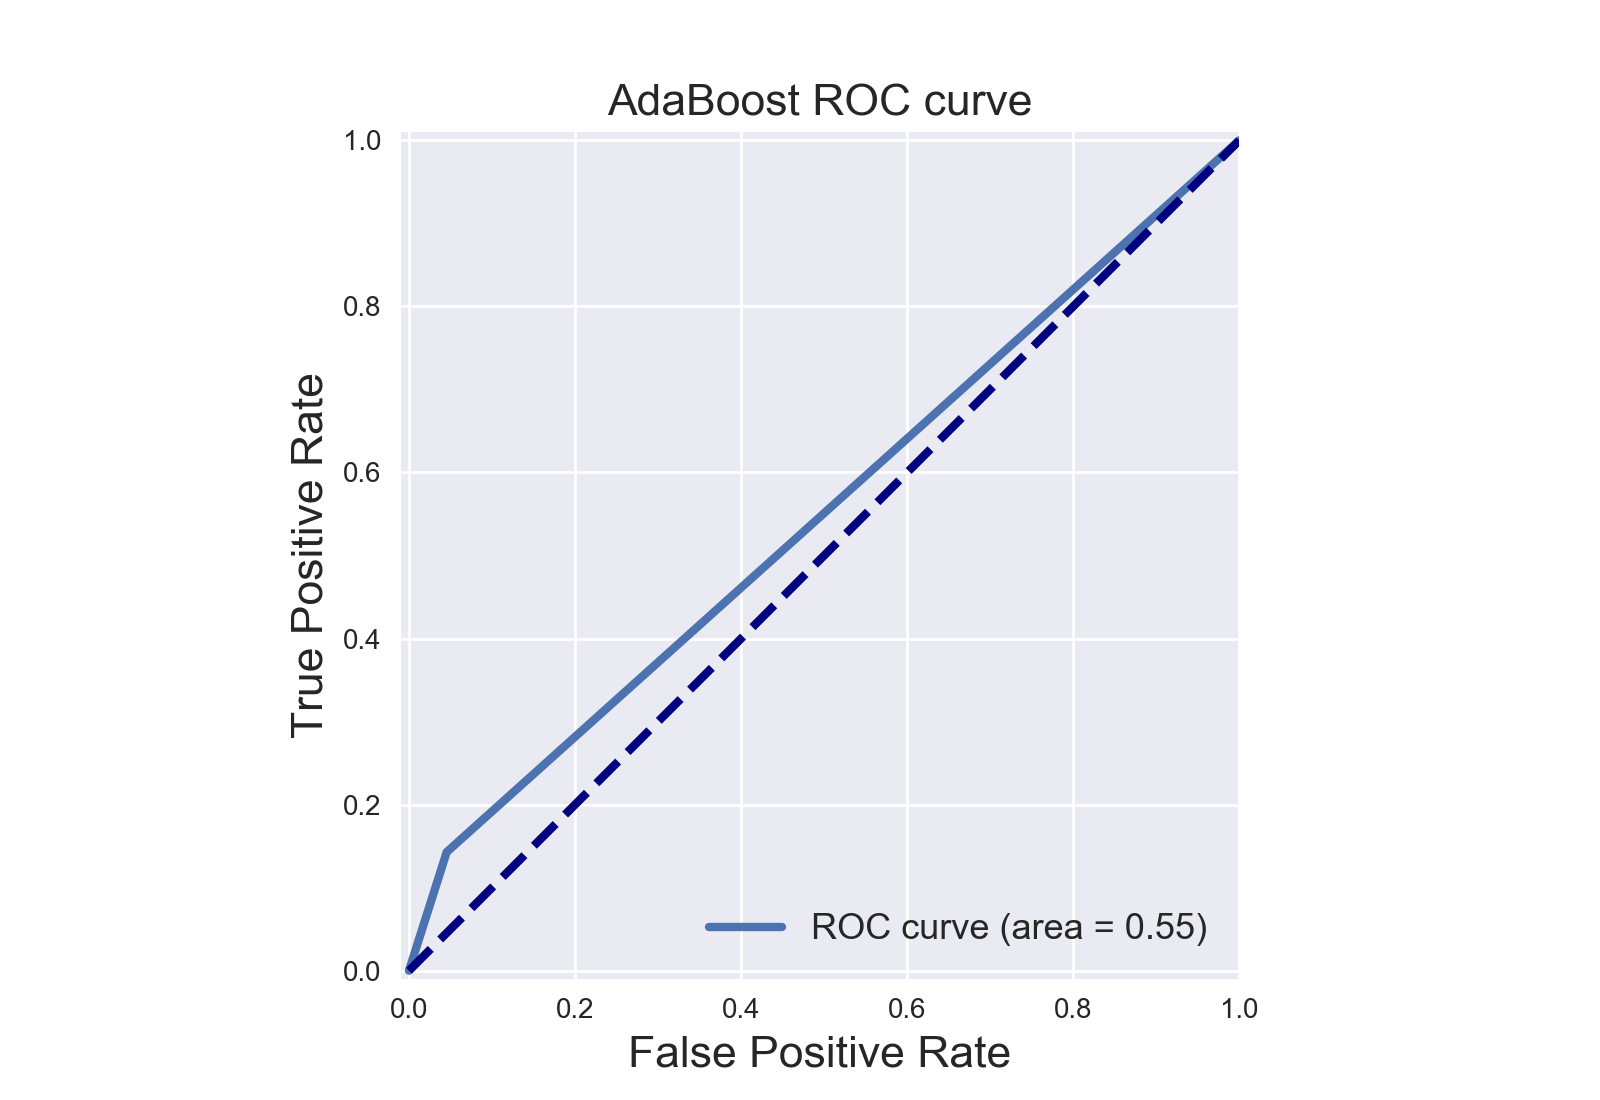

<IPython.core.display.Javascript object>


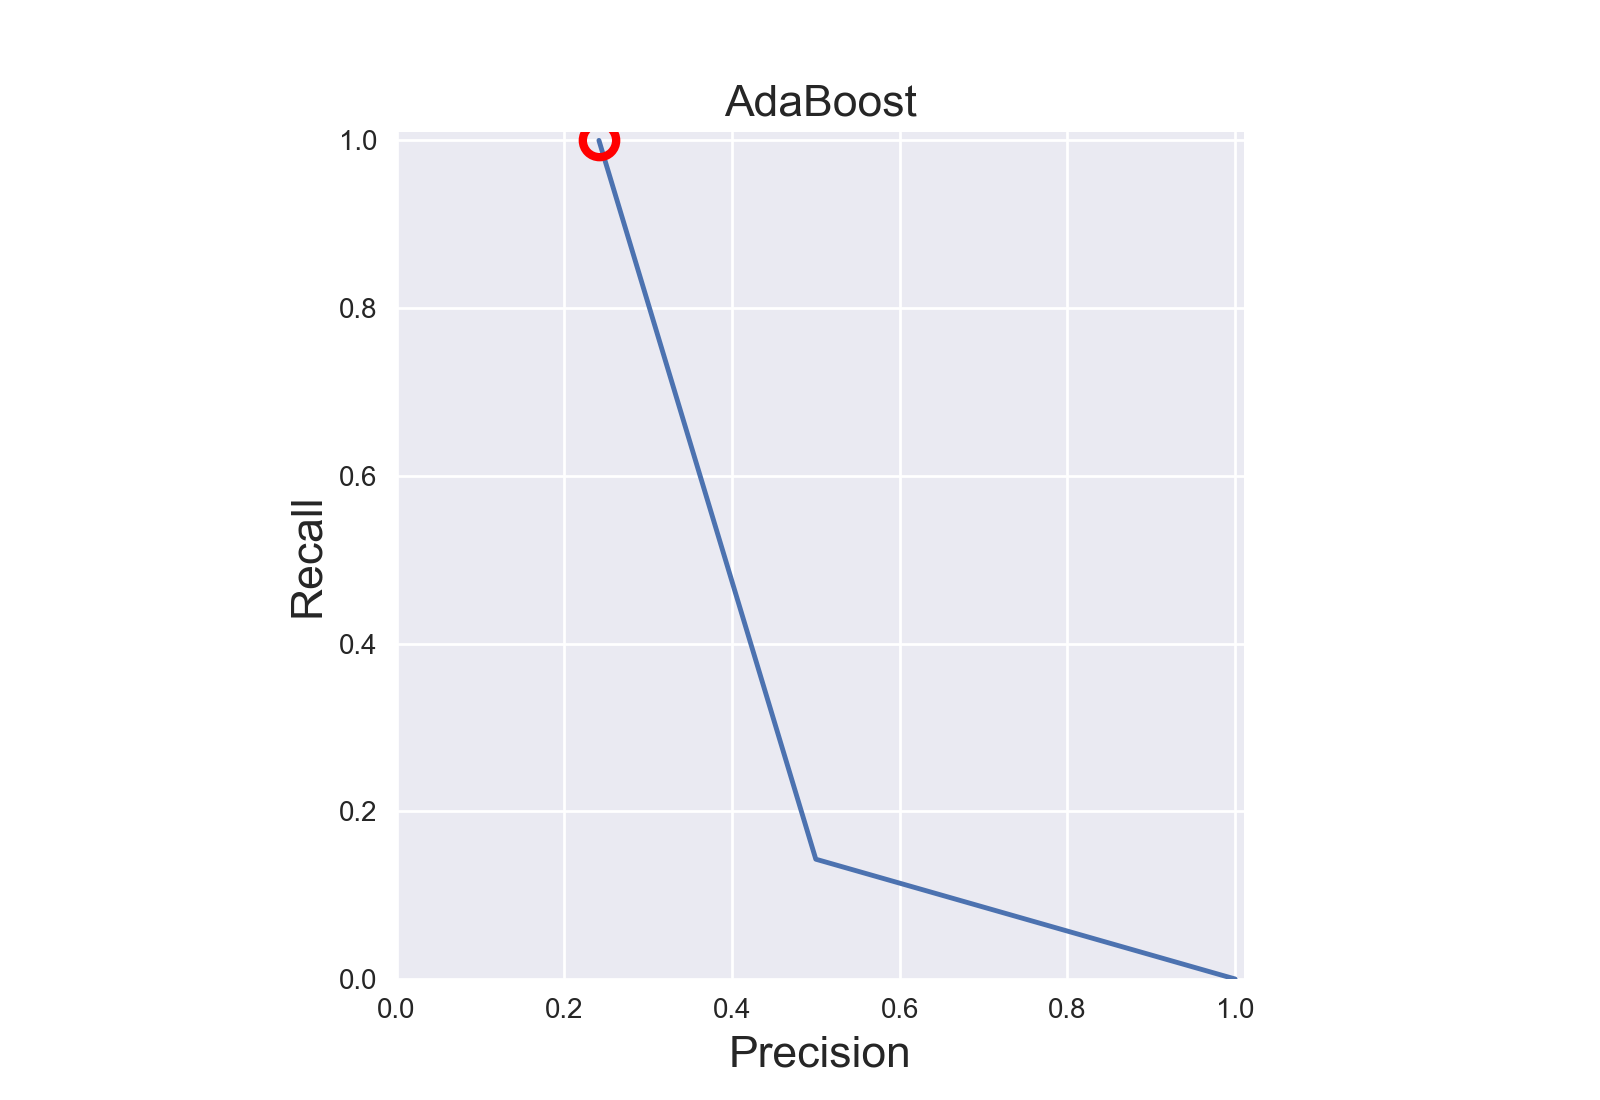

AdaBoost 
             precision    recall  f1-score   support

          0       0.78      0.95      0.86        22
          1       0.50      0.14      0.22         7

avg / total       0.71      0.76      0.70        29



<IPython.core.display.Javascript object>


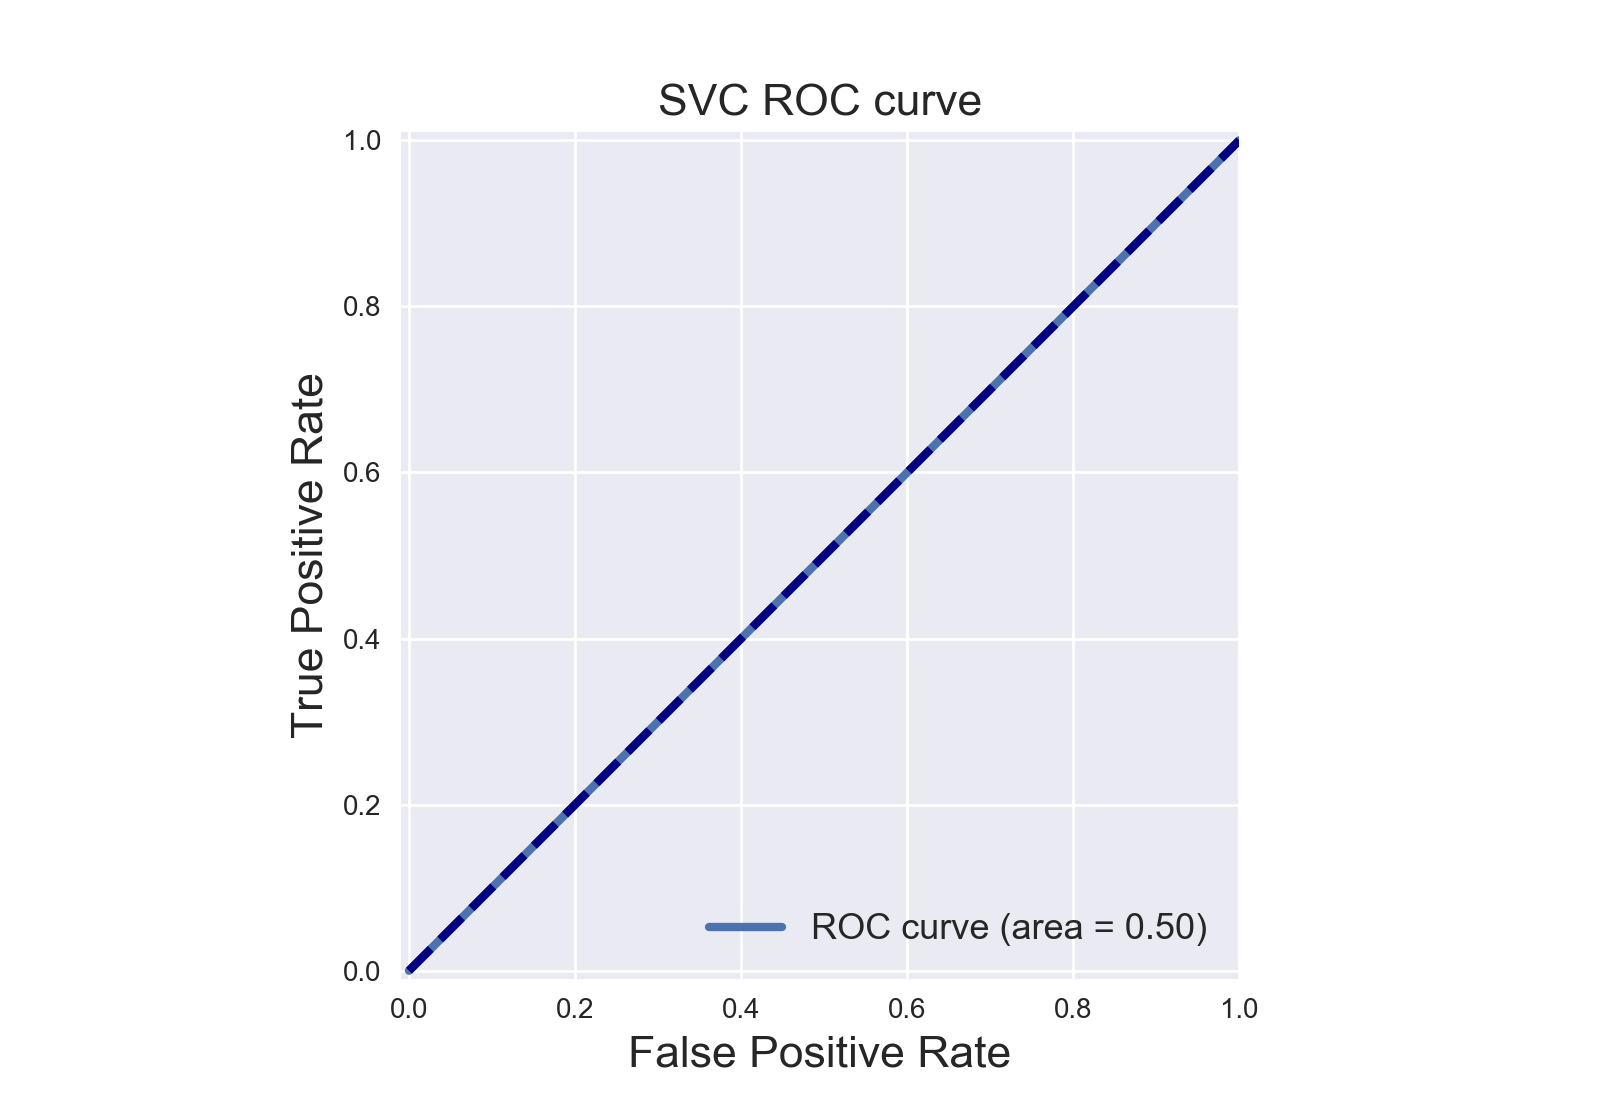

<IPython.core.display.Javascript object>


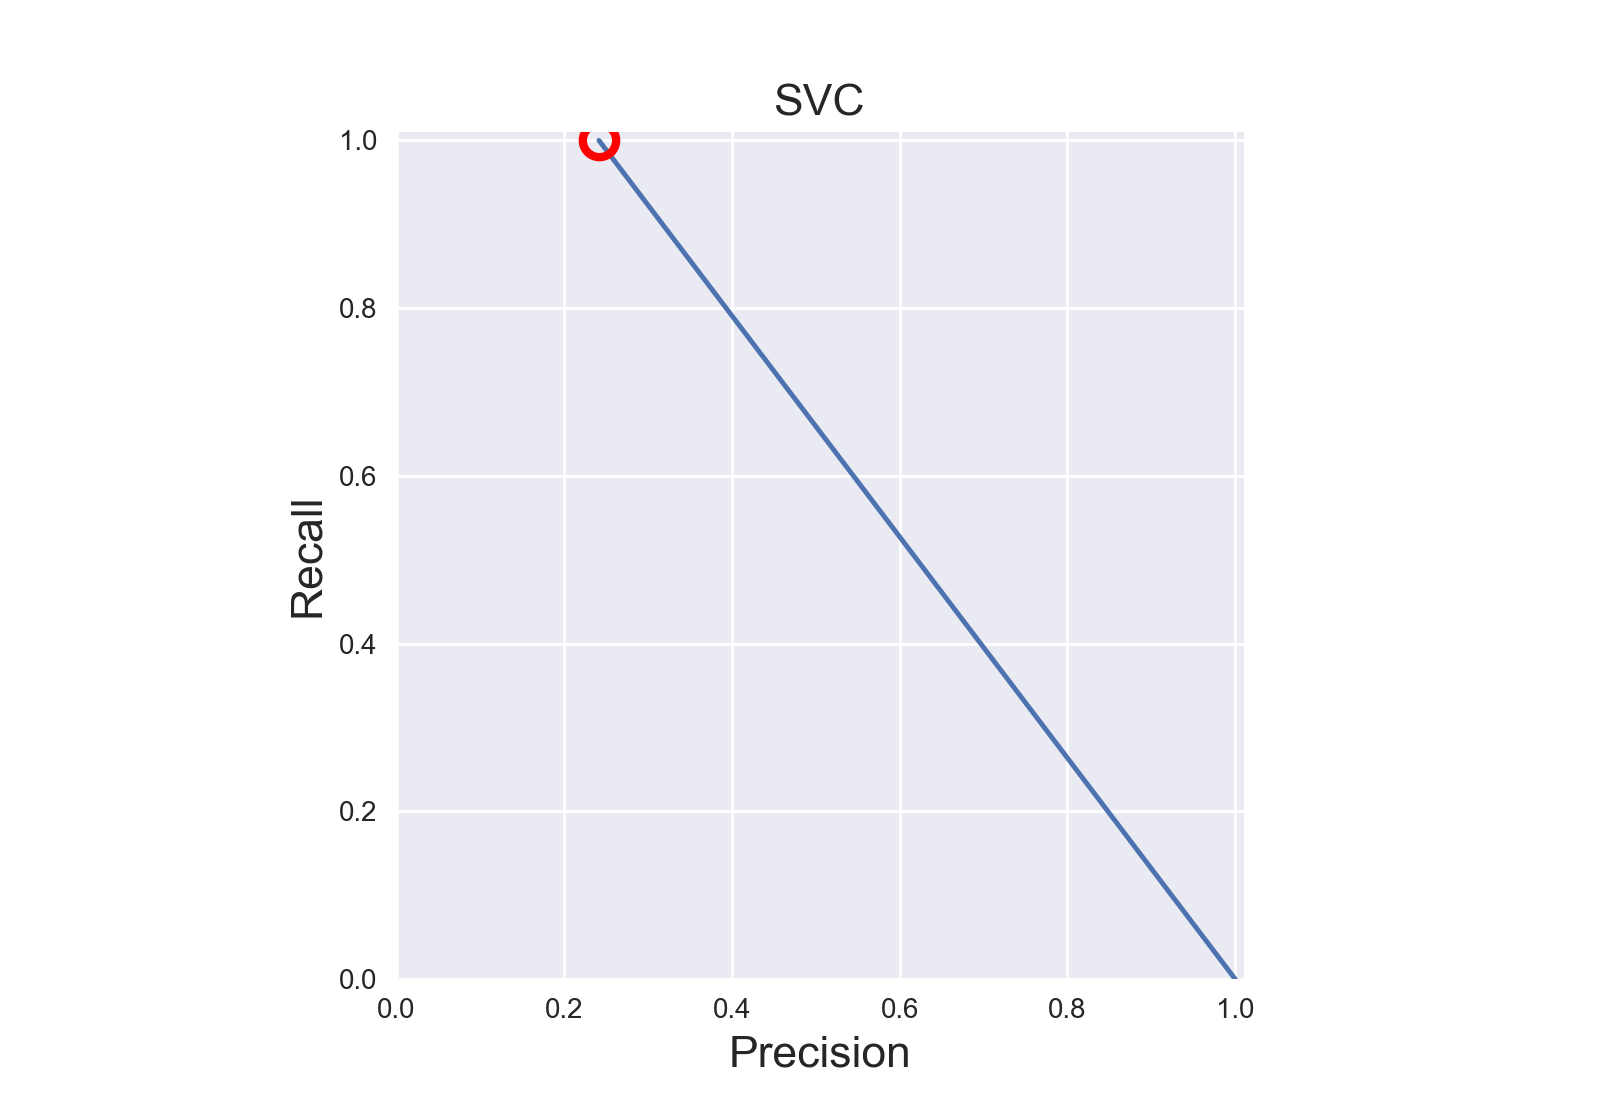

SVC 
             precision    recall  f1-score   support

          0       0.76      1.00      0.86        22
          1       0.00      0.00      0.00         7

avg / total       0.58      0.76      0.65        29

========Accuracy========
GradientBoost Acc Score: 0.904348+/-(0.050704) TestSet Acc Score:0.724138 
Random Forest Acc Score: 0.913043+/-(0.038888) TestSet Acc Score:0.724138 
AdaBoost Acc Score: 0.886957+/-(0.034783) TestSet Acc Score:0.758621 
SVC Acc Score: 0.904348+/-(0.063900) TestSet Acc Score:0.758621 

========Precision========
GradientBoost Precision Score: 0.150000+/-(0.200000) TestSet Precision Score:0.664014 
Random Forest Precision Score: 0.300000+/-(0.400000) TestSet Precision Score:0.568966 
AdaBoost Precision Score: 0.116667+/-(0.145297) TestSet Precision Score:0.710728 
SVC Precision Score: 0.000000+/-(0.000000) TestSet Precision Score:0.575505 

========Recall========
GradientBoost Recall Score: 0.166667+/-(0.210819) TestSet Recall Score:0.724138 
Rando

<IPython.core.display.Javascript object>


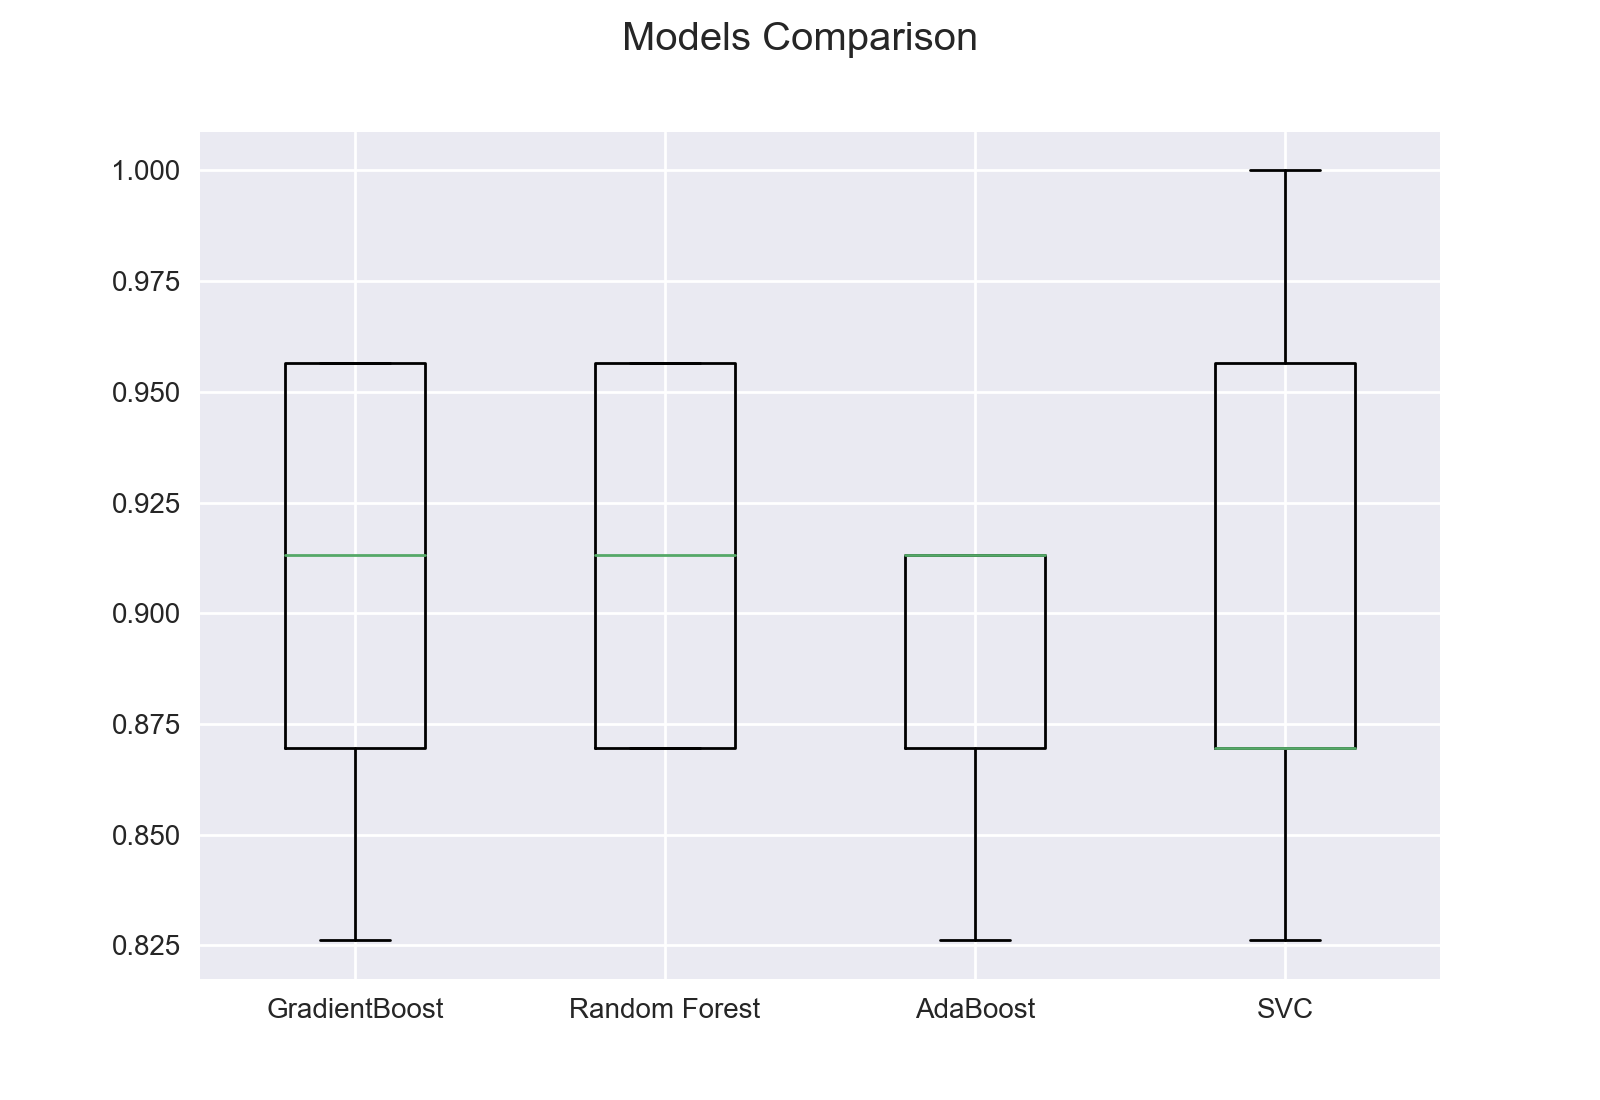

In [34]:
# ensembles
ensembles = []
ensembles.append(('GradientBoost', GB_clf))
ensembles.append(('Random Forest', RF_clf)) 
ensembles.append(('AdaBoost', ADA_clf))
ensembles.append(('SVC', SVC_clf))
results = []
names = []
AccScore = []
PrecScore = []
RecallScore = []

for name, model in ensembles:
    kfold = KFold(n_splits=5, shuffle = True, random_state=None)
    ####
    acc_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='accuracy')
    pre_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='precision')
    recall_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='recall')
    ####
    results.append(acc_results)
    names.append(name)
    model.fit(Xtrain,ytrain)
    
    y_pred = model.predict(Xtest)
    
    accscore = accuracy_score(ytest, y_pred)
    prescore = precision_score(ytest, y_pred, average='weighted') 
    recallscore = recall_score(ytest, y_pred, average='weighted')
    
    accmsg = "%s Acc Score: %f+/-(%f) TestSet Acc Score:%f "% (name, acc_results.mean(), acc_results.std(),accscore)
    AccScore.append(accmsg)

    premsg = "%s Precision Score: %f+/-(%f) TestSet Precision Score:%f "% (name, pre_results.mean(), pre_results.std(), prescore)
    PrecScore.append(premsg)
    
    recmsg = "%s Recall Score: %f+/-(%f) TestSet Recall Score:%f "% (name, recall_results.mean(), recall_results.std(), recallscore)
    RecallScore.append(recmsg)
    
    fpr_lr, tpr_lr, _ = roc_curve(ytest, y_pred)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_lr, tpr_lr, lw=3, label='ROC curve (area = {:0.2f})'.format( roc_auc_lr))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(name + ' ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')

    
    precision, recall, thresholds = precision_recall_curve(ytest, y_pred)
    closest_zero = np.argmin(np.abs(thresholds))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]

    plt.figure()
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.plot(precision, recall, label='Precision-Recall Curve')
    plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
    plt.title(name, fontsize=16)
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Recall', fontsize=16)
    plt.axes().set_aspect('equal')
    plt.show()
    print name,'\n',classification_report(ytest, y_pred)
    
print '========Accuracy========'
for i in AccScore:
    print(i)
print '\n','========Precision========'
for i in PrecScore:
    print(i)
print '\n','========Recall========'
for i in RecallScore:
    print(i)
    
fig = plt.figure()
fig.suptitle('Models Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names)
plt.show()


### 模型評估
1. ＳＶＣ，表現最佳，std小，不需要進一步調參
2. NaiveBays 大起大落
3. Ada, RF 進一步調參，優化

### 参数调整

- AdaBoost Tunning

In [97]:
param_test = {'learning_rate':[0.3,0.2,0.1,0.09],
               'n_estimators':[i for i in range (5,16,2)] } 
ada_model = AdaBoostClassifier()

kfold = KFold(n_splits=5, shuffle = True,random_state=None)
Gridsearch = GridSearchCV(estimator = ada_model, param_grid = param_test, scoring='accuracy', cv=kfold)
Gridsearch.fit(Xtrain, ytrain)

print('Best score: {}'.format(Gridsearch.best_score_))
print('Best parameters: {}'.format(Gridsearch.best_params_))
print('Best estimator: {}'.format(Gridsearch.best_estimator_ ))

Best score: 0.886956521739
Best parameters: {'n_estimators': 15, 'learning_rate': 0.1}
Best estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=15, random_state=None)


<IPython.core.display.Javascript object>


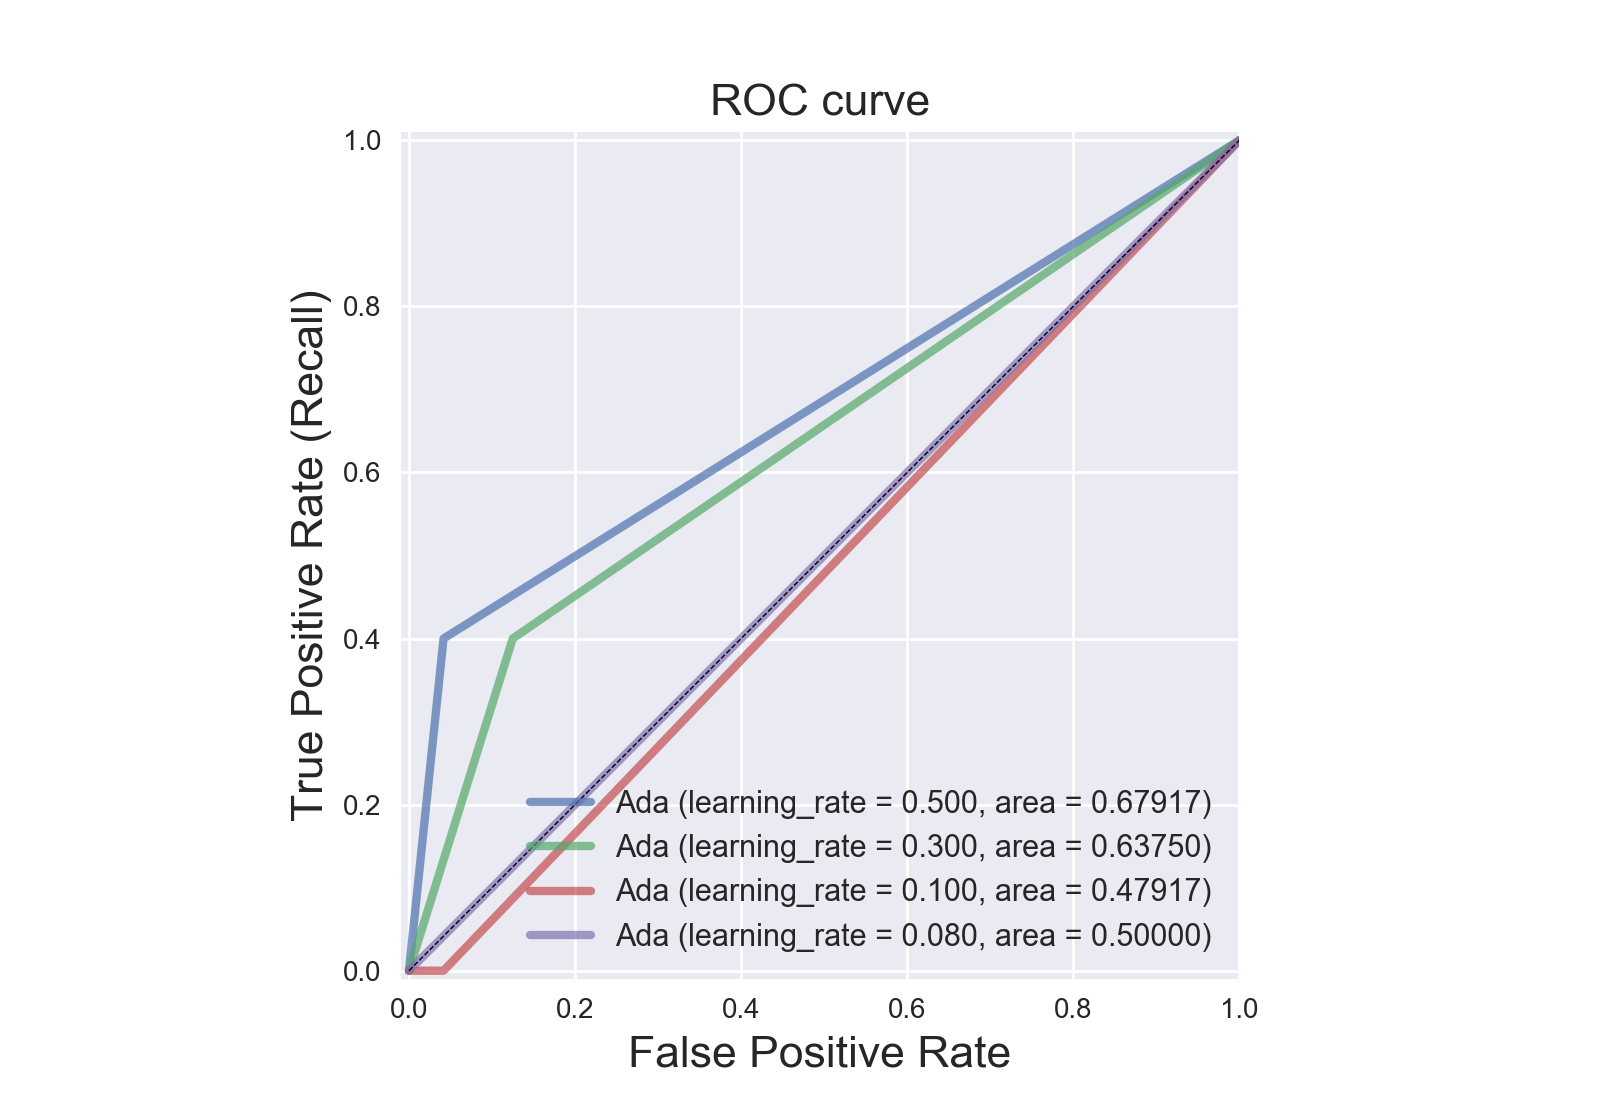

learning_rate = 0.500  accuracy = 0.862   AUC = 0.679
learning_rate = 0.300  accuracy = 0.793   AUC = 0.637
learning_rate = 0.100  accuracy = 0.793   AUC = 0.479
learning_rate = 0.080  accuracy = 0.828   AUC = 0.500


In [128]:
ada_model = AdaBoostClassifier()
kfold = KFold(n_splits=5, shuffle = True, random_state=None)
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [0.5,0.3,0.1,0.08]:
    ada_model = AdaBoostClassifier(learning_rate=g, n_estimators=11)
    ada_model.fit(Xtrain, ytrain)
    y_score_ada = ada_model.predict(Xtest)
    fpr_ada, tpr_ada, _ = roc_curve(ytest, y_score_ada)
    roc_auc_ada = auc(fpr_ada, tpr_ada)
    cv_results = cross_val_score(model, Xtrain, ytrain, cv=kfold, scoring='accuracy')
    accuracy_ada = ada_model.score(Xtest, ytest)
    print("learning_rate = {:.3f}  Test Set accuracy = {:.3f}  Test Set AUC = {:.3f}".format(g, accuracy_ada, 
                                                                    roc_auc_ada))
    plt.plot(fpr_ada, tpr_ada, lw=3, alpha=0.7, 
             label='Ada (learning_rate = {:0.3f}, area = {:0.5f})'.format(g, roc_auc_ada))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve', fontsize=16)
plt.axes().set_aspect('equal')

plt.show()

In [52]:
model = AdaBoostClassifier(algorithm='SAMME',base_estimator=SVC(), learning_rate=0.1, n_estimators=15, random_state=None)
model.fit(Xtrain,ytrain)
y_pred = model.predict(Xtest)
print classification_report(ytest, y_pred)

             precision    recall  f1-score   support

          0       0.76      1.00      0.86        22
          1       0.00      0.00      0.00         7

avg / total       0.58      0.76      0.65        29



- Random Forest Tunning

In [99]:
param_test={'n_estimators' : [i for i in range(10,50,10)],
           'criterion':['gini','entropy'],
           'max_depth':[2,3,4,5] } #
rf_model = RandomForestClassifier()

kfold = KFold(n_splits=5, shuffle = True,random_state=9487)
Gridsearch = GridSearchCV(estimator = rf_model, param_grid = param_test, scoring='accuracy', cv=kfold)
Gridsearch.fit(Xtrain, ytrain)

print('Best score: {}'.format(Gridsearch.best_score_))
print('Best parameters: {}'.format(Gridsearch.best_params_))
print('Best estimator: {}'.format(Gridsearch.best_estimator_ ))

Best score: 0.886956521739
Best parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 5}
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


<IPython.core.display.Javascript object>


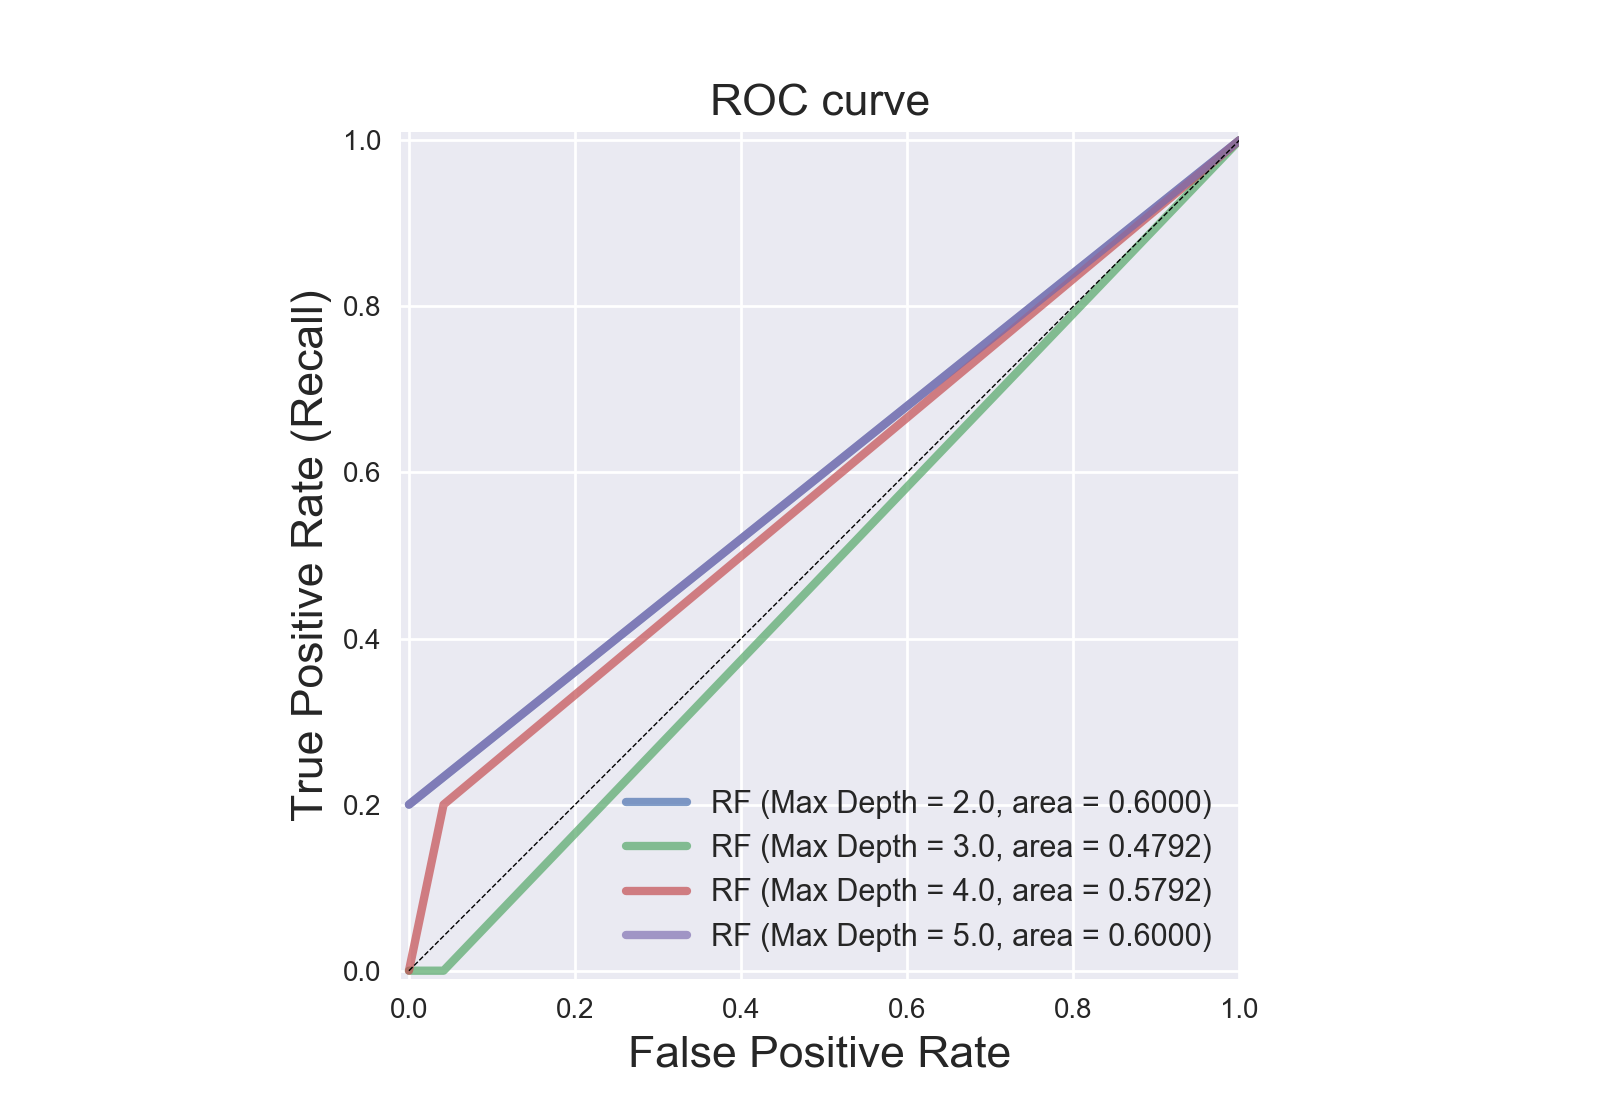

max_depth =  2  Test Set accuracy =  0.8621  Test Set AUC =  0.6000
max_depth =  3  Test Set accuracy =  0.7931  Test Set AUC =  0.4792
max_depth =  4  Test Set accuracy =  0.8276  Test Set AUC =  0.5792
max_depth =  5  Test Set accuracy =  0.8621  Test Set AUC =  0.6000


In [133]:
rf_model = RandomForestClassifier()

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [2,3,4,5]:
    ada_model = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=g)
    ada_model.fit(Xtrain, ytrain)
    y_score_ada = ada_model.predict(Xtest)
    fpr_ada, tpr_ada, _ = roc_curve(ytest, y_score_ada)
    roc_auc_ada = auc(fpr_ada, tpr_ada)
    accuracy_ada = ada_model.score(Xtest, ytest)
    print("max_depth = {: d}  Test Set accuracy = {:.4f}  Test Set AUC = {:.4f}".format(g, accuracy_ada, 
                                                                    roc_auc_ada))
    plt.plot(fpr_ada, tpr_ada, lw=3, alpha=0.7, 
             label='RF (Max Depth = {:0.1f}, area = {:0.4f})'.format(g, roc_auc_ada))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve', fontsize=16)
plt.axes().set_aspect('equal')

plt.show()

In [51]:
model = RandomForestClassifier(n_estimators= 20, criterion='gini', max_depth=5)
model.fit(Xtrain,ytrain)
y_pred = model.predict(Xtest)
print classification_report(ytest, y_pred)

             precision    recall  f1-score   support

          0       0.78      0.95      0.86        22
          1       0.50      0.14      0.22         7

avg / total       0.71      0.76      0.70        29



- Gradient Boosting Tunning

In [115]:
param_test={'learning_rate':[1/(10**i) for i in range(1,4)],
           'max_depth':[2,3,4,5],
           'min_samples_split':[2,3,4,5],
           'subsample':[i/10 for i in range(7,10)]}

gb_model = GradientBoostingClassifier()

kfold = KFold(n_splits=5, shuffle = True,random_state=9487)
Gridsearch = GridSearchCV(estimator = gb_model, param_grid = param_test, scoring='accuracy', cv=kfold)
Gridsearch.fit(Xtrain, ytrain)

print('Best score: {}'.format(Gridsearch.best_score_))
print('Best parameters: {}'.format(Gridsearch.best_params_))
print('Best estimator: {}'.format(Gridsearch.best_estimator_ ))

Best score: 0.895652173913
Best parameters: {'min_samples_split': 2, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 2}
Best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.9, verbose=0, warm_start=False)


<IPython.core.display.Javascript object>


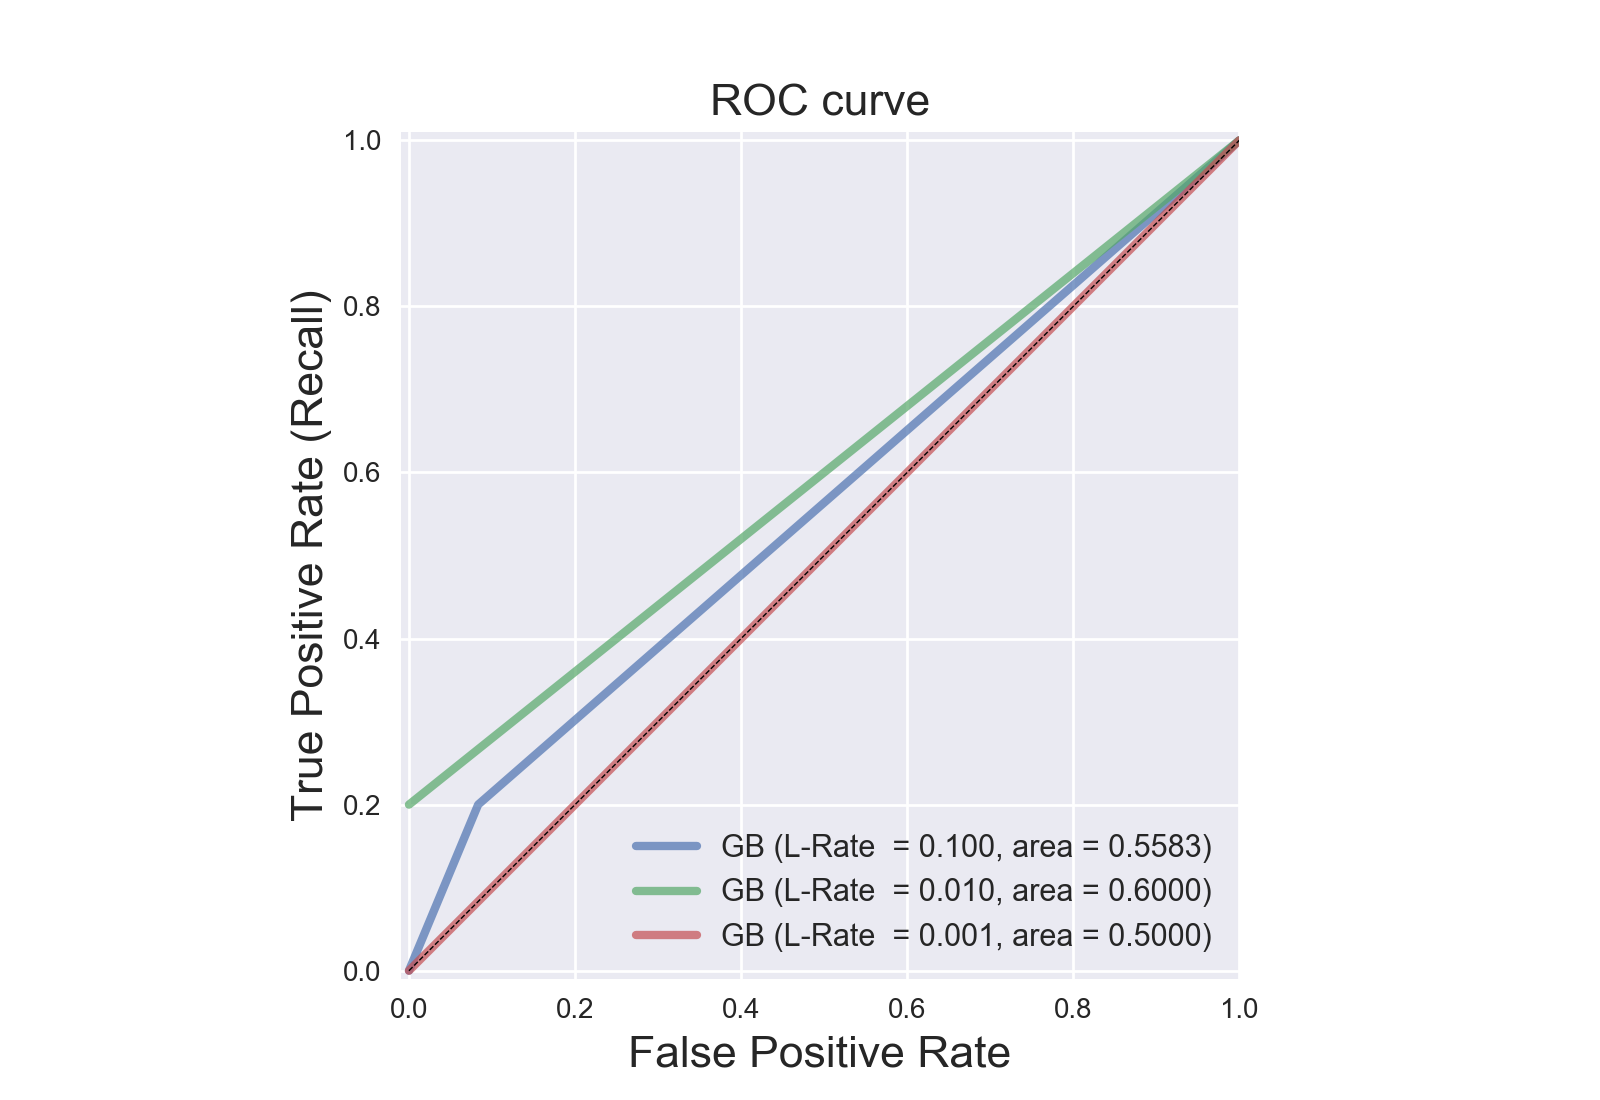

L-Rate = 0.1000  Test Set accuracy =  0.7931 Test Set AUC =  0.5583
L-Rate = 0.0100  Test Set accuracy =  0.8621 Test Set AUC =  0.6000
L-Rate = 0.0010  Test Set accuracy =  0.8276 Test Set AUC =  0.5000


In [134]:
gb_model = GradientBoostingClassifier()
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [1/(10**i) for i in range(1,4)]:
    ada_model = GradientBoostingClassifier( learning_rate= g )
    ada_model.fit(Xtrain, ytrain)
    y_score_ada = ada_model.predict(Xtest)
    fpr_ada, tpr_ada, _ = roc_curve(ytest, y_score_ada)
    roc_auc_ada = auc(fpr_ada, tpr_ada)
    accuracy_ada = ada_model.score(Xtest, ytest)
    print("L-Rate = {:.4f}  Test Set accuracy = {: .4f} Test Set AUC = {: .4f}".format(g, accuracy_ada, 
                                                                    roc_auc_ada))
    plt.plot(fpr_ada, tpr_ada, lw=3, alpha=0.7, 
             label='GB (L-Rate  = {:0.3f}, area = {:0.4f})'.format(g, roc_auc_ada))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve', fontsize=16)
plt.axes().set_aspect('equal')

plt.show()

In [53]:
model = GradientBoostingClassifier(min_samples_split=2, subsample= 0.9, learning_rate=0.01, max_depth= 2)
model.fit(Xtrain,ytrain)
y_pred = model.predict(Xtest)
print classification_report(ytest, y_pred)

             precision    recall  f1-score   support

          0       0.78      0.95      0.86        22
          1       0.50      0.14      0.22         7

avg / total       0.71      0.76      0.70        29



## 優化，調參後的GradientBoostingClassifier()
1. 精準度平均：84%
2. 回召率平均：79%
3. F1-Score 平均：73%

In [46]:
enron_data = {}

for i in df.index:
    enron_attr = {}
    for j in features_list:        
        enron_attr[j] = df.loc[i][j]
    enron_data[i] = enron_attr
enron_data

{'ALLEN PHILLIP K': {'bonus': 4175000.0,
  'deferral_payments': 2869717.0,
  'deferred_income': -3081055.0,
  'director_fees': 0.0,
  'exercised_stock_options': 1729541.0,
  'expenses': 13868.0,
  'extra_payment_std': 10.062711884294258,
  'from_messages': 2195.0,
  'from_poi_to_this_person': 47.0,
  'from_this_person_to_poi': 65.0,
  'ica_1': 0.13376915383936097,
  'ica_2': 0.057705417001888568,
  'ica_3': 0.042402499652098802,
  'ica_4': -0.014503535666925338,
  'kca_1': -0.13418565382889375,
  'kca_2': -0.057185149279721251,
  'kca_3': 0.014546237391032146,
  'kca_4': -0.041772026285308489,
  'loan_advances': 0.0,
  'long_term_incentive': 304805.0,
  'other': 152.0,
  'pca_1': 758581.30501521984,
  'pca_2': -1563781.6585456659,
  'pca_3': 2918085.2005247562,
  'pca_4': 1299085.2809710812,
  'restricted_stock': 126027.0,
  'restricted_stock_deferred': -126027.0,
  'salary': 201955.0,
  'shared_receipt_with_poi': 1407.0,
  'to_messages': 2902.0,
  'total_payments': 4484442.0,
  'total

In [54]:
features_list = list(feat_labels[indices])[:-15]

clf = Gridsearch.best_estimator_  

pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(enron_data, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )
